# Анализ качества воздуха в европейских странах

Данный проект направлен на исследование показателей, входящих в EAQI - индекс качества воздуха по европейскому стандарту.

In [ ]:
import requests
import pandas as pd
import numpy as np
import os
from bs4 import BeautifulSoup
import json
import openmeteo_requests
import requests_cache
from retry_requests import retry
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import folium

### Парсинг данных

In [ ]:
# Парсинг координат городов  и сохранение в json файл

url = "https://time-in.ru/coordinates/Russia"
url_edit = ""
countries = ['germany', 'denmark', 'greece', 'switzerland', 'spain', 'austria']
countries_on_russian = ['Германия', 'Дания', 'Греция', 'Швейцария', 'Испания', 'Австрия']
countries_for_datafarme = []
all_cities = []
latitude = []
longitude = []
result_data = pd.DataFrame()

# Переменная для создания списка с русскими названиями стран в датафрейме
for_dataframe = 0

# Цикл по странам
for country in countries:
    counter = 0

    # Меняем ссылку для поиска городов по необходимой стране
    url_edit = url.replace("Russia", country)
    r = requests.get(url_edit)
    soup = BeautifulSoup(r.text, 'html.parser')

    # Цикл по городам на сайте
    for i in soup.find_all('li'):

        # Пропускаем первые 11 строк с ненужной информацией
        if counter >= 11:

            # Подставляем название страны на русском
            countries_for_datafarme.append(countries_on_russian[for_dataframe])

            # Находим <a> с нужным атрибутом class и извлекаем из него текст
            city = i.find('a', {'class':'coordinates-items-left'}).text
            all_cities.append(city)

            # Находим <div> с нужным атрибутом class и извлекаем из него текст
            coordinates = i.find('div', {'class': 'coordinates-items-right'}).text

            # Разделяем координаты нга широту и долготу
            latitude_value, longitude_value = map(float, coordinates.split(','))

            # Добавляем коордианты в отдельные списки
            latitude.append(latitude_value)
            longitude.append(longitude_value)

        else: pass
        counter += 1

    for_dataframe += 1

# Формируем датафрейм из городов и их координат
result_data['name'] = all_cities
result_data['country'] = countries_for_datafarme
result_data['latitude'] = latitude
result_data['longitude'] = longitude


# Создаем json файл и сохраняем в нужную папку
result_data_json = result_data.to_json('../data/source/cities_data.json', orient='records')

print("Данные были сохранены в файл 'cities_data.json', папка data/source")

Данные были сохранены в файл 'cities_data.json', папка data/source


In [ ]:
# Загрузка данных из JSON-файла
json_file_path = "cities_data.json"
with open(json_file_path, "r", encoding="utf-8") as file:
    cities_data = json.load(file)

Извлечение данных из json файла было разделено на 2 части (первые 200 кортежей, остальные записи), так как клиент Open-Meteo API не позволяет делать все запросы одним разом (видимо, для него это многовато).

In [ ]:
# Извлечение данных из первой половины JSON
names = [city["name"] for city in cities_data[:200]]
countries = [city["country"] for city in cities_data[:200]]
latitudes = [city["latitude"] for city in cities_data[:200]]
longitudes = [city["longitude"] for city in cities_data[:200]]

# Инициализация списка для хранения данных
data_records = []

# Настройка клиента Open-Meteo API с кэшем и повторными попытками
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)
# URL API
url = "https://archive-api.open-meteo.com/v1/archive"

In [ ]:
params = {
    "latitude": latitudes,
    "longitude": longitudes,
    "start_date": "2020-01-01",
    "end_date": "2021-12-31",
    "hourly": ["temperature_2m", "apparent_temperature", "precipitation", "wind_speed_10m", "wind_direction_10m"]
}

responses = openmeteo.weather_api(url, params=params)


# Обработка данных для каждого местоположения
for i, response in enumerate(responses):
    name = names[i]
    country = countries[i]
    latitude = latitudes[i]
    longitude = longitudes[i]

    print(f"Обработка данных для {name}, {country}: {latitude}°N, {longitude}°E")

    # Извлечение почасовых данных
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_apparent_temperature = hourly.Variables(1).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

    timestamps = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )

    # Формирование записей для DataFrame
    for time, temp, apparent_temp, precip, wind_speed, wind_dir in zip(
        timestamps, hourly_temperature_2m, hourly_apparent_temperature, hourly_precipitation,
        hourly_wind_speed_10m, hourly_wind_direction_10m
    ):
        data_records.append({
            "date": time,
            "country": country,
            "city": name,
            "latitude": latitude,
            "longitude": longitude,
            "temperature_2m": temp,
            "apparent_temperature": apparent_temp,
            "precipitation": precip,
            "wind_speed_10m": wind_speed,
            "wind_direction_10m": wind_dir
        })


Обработка данных для Берлин, Германия: 52.52°N, 13.41°E
Обработка данных для Ален, Германия: 51.76°N, 7.89°E
Обработка данных для Ален, Германия: 48.84°N, 10.09°E
Обработка данных для Арнсберге, Германия: 51.38°N, 8.08°E
Обработка данных для Аугсбург, Германия: 48.37°N, 10.9°E
Обработка данных для Ахен, Германия: 50.78°N, 6.08°E
Обработка данных для Ашаффенбург, Германия: 49.98°N, 9.15°E
Обработка данных для Бад-Зальцуфлен, Германия: 52.09°N, 8.74°E
Обработка данных для Бад-Хомбург, Германия: 50.23°N, 8.62°E
Обработка данных для Баден-Баден, Германия: 48.76°N, 8.24°E
Обработка данных для Байройт, Германия: 49.95°N, 11.58°E
Обработка данных для Бамберг, Германия: 49.9°N, 10.9°E
Обработка данных для Бергем, Германия: 50.96°N, 6.64°E
Обработка данных для Бергиш Гладбах, Германия: 50.99°N, 7.13°E
Обработка данных для Бергкамен, Германия: 51.62°N, 7.64°E
Обработка данных для Билефельд, Германия: 52.03°N, 8.53°E
Обработка данных для Бонн, Германия: 50.73°N, 7.1°E
Обработка данных для Ботроп,

In [ ]:
# Извлечение данных из второй половины JSON
names = [city["name"] for city in cities_data[200:]]
countries = [city["country"] for city in cities_data[200:]]
latitudes = [city["latitude"] for city in cities_data[200:]]
longitudes = [city["longitude"] for city in cities_data[200:]]

params = {
    "latitude": latitudes,
    "longitude": longitudes,
    "start_date": "2020-01-01",
    "end_date": "2021-12-31",
    "hourly": ["temperature_2m", "apparent_temperature", "precipitation", "wind_speed_10m", "wind_direction_10m"]
}

responses = openmeteo.weather_api(url, params=params)


# Обработка данных для каждого местоположения
for i, response in enumerate(responses):
    name = names[i]
    country = countries[i]
    latitude = latitudes[i]
    longitude = longitudes[i]

    print(f"Обработка данных для {name}, {country}: {latitude}°N, {longitude}°E")

    # Извлечение почасовых данных
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_apparent_temperature = hourly.Variables(1).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

    timestamps = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )

    # Формирование записей для DataFrame
    for time, temp, apparent_temp, precip, wind_speed, wind_dir in zip(
        timestamps, hourly_temperature_2m, hourly_apparent_temperature, hourly_precipitation,
        hourly_wind_speed_10m, hourly_wind_direction_10m
    ):
        data_records.append({
            "date": time,
            "country": country,
            "city": name,
            "latitude": latitude,
            "longitude": longitude,
            "temperature_2m": temp,
            "apparent_temperature": apparent_temp,
            "precipitation": precip,
            "wind_speed_10m": wind_speed,
            "wind_direction_10m": wind_dir
        })


Обработка данных для Кавала, Греция: 40.94°N, 24.41°E
Обработка данных для Каламария, Греция: 40.58°N, 22.95°E
Обработка данных для Каламата, Греция: 37.04°N, 22.11°E
Обработка данных для Каллифея, Греция: 37.95°N, 23.7°E
Обработка данных для Ламия, Греция: 38.9°N, 22.43°E
Обработка данных для Лариса, Греция: 39.64°N, 22.42°E
Обработка данных для Перистерион, Греция: 38.02°N, 23.69°E
Обработка данных для Петроуполис, Греция: 38.04°N, 23.68°E
Обработка данных для Пирей, Греция: 37.94°N, 23.65°E
Обработка данных для Родос, Греция: 36.44°N, 28.22°E
Обработка данных для Салоники, Греция: 40.64°N, 22.93°E
Обработка данных для Серре, Греция: 41.09°N, 23.55°E
Обработка данных для Трикала, Греция: 39.55°N, 21.77°E
Обработка данных для Халкида, Греция: 38.46°N, 23.6°E
Обработка данных для Ханья, Греция: 35.51°N, 24.03°E
Обработка данных для Берн, Швейцария: 46.95°N, 7.45°E
Обработка данных для Базель, Швейцария: 47.56°N, 7.57°E
Обработка данных для Винтертур, Швейцария: 47.51°N, 8.72°E
Обработк

In [ ]:
# Создание итогового DataFrame
final_dataframe = pd.DataFrame(data_records)

In [ ]:
final_dataframe.head()

,date,country,city,latitude,longitude,temperature_2m,apparent_temperature,precipitation,wind_speed_10m,wind_direction_10m
0,2020-01-01 00:00:00+00:00,Германия,Берлин,52.52,13.41,2.1085,-1.317814,0.0,10.308831,282.094727
1,2020-01-01 01:00:00+00:00,Германия,Берлин,52.52,13.41,1.8085,-1.758666,0.0,11.159999,270.000000
2,2020-01-01 02:00:00+00:00,Германия,Берлин,52.52,13.41,1.2085,-2.283353,0.0,10.137691,276.115417
3,2020-01-01 03:00:00+00:00,Германия,Берлин,52.52,13.41,0.3585,-3.139605,0.0,9.422101,276.581848
4,2020-01-01 04:00:00+00:00,Германия,Берлин,52.52,13.41,-0.0415,-3.608093,0.0,9.422101,276.581848


In [ ]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6022992 entries, 0 to 6022991
Data columns (total 10 columns):
 #   Column                Dtype              
---  ------                -----              
 0   date                  datetime64[ns, UTC]
 1   country               object             
 2   city                  object             
 3   latitude              float64            
 4   longitude             float64            
 5   temperature_2m        float32            
 6   apparent_temperature  float32            
 7   precipitation         float32            
 8   wind_speed_10m        float32            
 9   wind_direction_10m    float32            
dtypes: datetime64[ns, UTC](1), float32(5), float64(2), object(2)
memory usage: 344.6+ MB


In [ ]:
final_dataframe.to_csv('weather_in_cities_2020.csv', index=False)

print("Данные были сохранены в файл 'weather_in_cities.csv', папка data/source")

Данные были сохранены в файл 'weather_in_cities.csv', папка data/source


In [ ]:
print(len(cities_data)) # Кол-во городов в справочнике
cities_data[-1]

358


{'name': 'Филлах', 'country': 'Австрия', 'latitude': 46.61, 'longitude': 13.86}

In [ ]:
# Open-Meteo — это API погоды с открытым исходным кодом, предлагающий бесплатный доступ для некоммерческого использования
url = "https://air-quality-api.open-meteo.com/v1/air-quality"

# Для сбора данных
data_air_quality = []

In [ ]:
# Настройка сессии для работы с API
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600) # кэширование для хранения ответов на запросы
retry_session = retry(cache_session, retries = 3, backoff_factor = 2) # повторная попытка в случае ошибки
openmeteo = openmeteo_requests.Client(session = retry_session)

In [ ]:
def parser_air_quality(cities_data):
    # Извлечение данных из первой половины JSON
    cyties     = [city["name"]      for city in cities_data]
    countries  = [city["country"]   for city in cities_data]
    latitudes  = [city["latitude"]  for city in cities_data]
    longitudes = [city["longitude"] for city in cities_data]

    # Параметры для запроса (одинаковые для всех городов)
    params = {
        "hourly": [
            "pm10", "pm2_5", "carbon_monoxide", "carbon_dioxide",
            "nitrogen_dioxide", "sulphur_dioxide", "ozone",
            "aerosol_optical_depth", "dust", "uv_index",
            "uv_index_clear_sky", "ammonia", "methane",
            "alder_pollen", "birch_pollen", "grass_pollen",
            "mugwort_pollen", "olive_pollen", "ragweed_pollen"
        ],
        "latitude": latitudes,
        "longitude": longitudes,
        "start_date": "2020-01-01",
        "end_date": "2024-12-31"
    }

    responses = openmeteo.weather_api(url, params=params)

    # Обработка данных для каждого местоположения + индикатор отслеживания
    for i, response in tqdm(enumerate(responses), desc="Обработка городов"):
        city      = cyties[i]
        country   = countries[i]
        latitude  = latitudes[i]
        longitude = longitudes[i]

        # Извлечение почасовых данных
        hourly = response.Hourly()
        timestamps = pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )

        data_dict = {
            "date":                  timestamps,
            "country":               country,
            "city":                  city,
            "latitude":              latitude,
            "longitude":             longitude,
            "pm10":                  hourly.Variables(0).ValuesAsNumpy(),
            "pm2_5":                 hourly.Variables(1).ValuesAsNumpy(),
            "carbon_monoxide":       hourly.Variables(2).ValuesAsNumpy(),
            "carbon_dioxide":        hourly.Variables(3).ValuesAsNumpy(),
            "nitrogen_dioxide":      hourly.Variables(4).ValuesAsNumpy(),
            "sulphur_dioxide":       hourly.Variables(5).ValuesAsNumpy(),
            "ozone":                 hourly.Variables(6).ValuesAsNumpy(),
            "aerosol_optical_depth": hourly.Variables(7).ValuesAsNumpy(),
            "dust":                  hourly.Variables(8).ValuesAsNumpy(),
            "uv_index":              hourly.Variables(9).ValuesAsNumpy(),
            "uv_index_clear_sky":    hourly.Variables(10).ValuesAsNumpy(),
            "ammonia":               hourly.Variables(11).ValuesAsNumpy(),
            "methane":               hourly.Variables(12).ValuesAsNumpy(),
            "alder_pollen":          hourly.Variables(13).ValuesAsNumpy(),
            "birch_pollen":          hourly.Variables(14).ValuesAsNumpy(),
            "grass_pollen":          hourly.Variables(15).ValuesAsNumpy(),
            "mugwort_pollen":        hourly.Variables(16).ValuesAsNumpy(),
            "olive_pollen":          hourly.Variables(17).ValuesAsNumpy(),
            "ragweed_pollen":        hourly.Variables(18).ValuesAsNumpy()
        }

        df = pd.DataFrame(data_dict)
        data_air_quality.append(df)

In [ ]:
# Разбиение данных json на две части, так как клиент Open-Meteo API не позволяет делать все запросы за раз (ограничения сайта)
half = len(cities_data) // 2
half

179

In [ ]:
parser_air_quality(cities_data[:half])

Обработка городов: 179it [00:00, 298.27it/s]


In [ ]:
# Второй запуск
parser_air_quality(cities_data[half:])

Обработка городов: 179it [00:00, 194.19it/s]


In [ ]:
# Создание итогового DataFrame
final_dataframe_air = pd.concat([pd.DataFrame(data) for data in data_air_quality], ignore_index=True)
final_dataframe_air.head()

,date,country,city,latitude,longitude,pm10,pm2_5,carbon_monoxide,carbon_dioxide,nitrogen_dioxide,...,uv_index,uv_index_clear_sky,ammonia,methane,alder_pollen,birch_pollen,grass_pollen,mugwort_pollen,olive_pollen,ragweed_pollen
0,2020-01-01 00:00:00+00:00,Германия,Штутгарт,48.78,9.18,43.599998,33.700001,377.0,NaN,43.299999,...,NaN,NaN,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 01:00:00+00:00,Германия,Штутгарт,48.78,9.18,52.299999,33.599998,362.0,NaN,43.299999,...,NaN,NaN,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 02:00:00+00:00,Германия,Штутгарт,48.78,9.18,53.599998,33.099998,383.0,NaN,41.500000,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01 03:00:00+00:00,Германия,Штутгарт,48.78,9.18,53.900002,35.299999,362.0,NaN,36.500000,...,NaN,NaN,1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01 04:00:00+00:00,Германия,Штутгарт,48.78,9.18,53.599998,35.299999,352.0,NaN,31.400000,...,NaN,NaN,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_dataframe_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15697584 entries, 0 to 15697583
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date                   object 
 1   country                object 
 2   city                   object 
 3   latitude               float64
 4   longitude              float64
 5   pm10                   float64
 6   pm2_5                  float64
 7   carbon_monoxide        float64
 8   carbon_dioxide         float64
 9   nitrogen_dioxide       float64
 10  sulphur_dioxide        float64
 11  ozone                  float64
 12  aerosol_optical_depth  float64
 13  dust                   float64
 14  uv_index               float64
 15  uv_index_clear_sky     float64
 16  ammonia                float64
 17  methane                float64
 18  alder_pollen           float64
 19  birch_pollen           float64
 20  grass_pollen           float64
 21  mugwort_pollen         float64
 22  olive_pollen    

In [ ]:
# Проверка, что нашлись все данные
358*(2*366*24 + 3*365*24) == final_dataframe_air.shape[0]

True

In [ ]:
final_dataframe_air.to_csv('air_quality.csv', index=False)

print("Данные были сохранены в файл 'air_quality.csv'")

Данные были сохранены в файл 'air_quality.csv'


### Соединение получившихся датафреймов

In [ ]:
# Загрузка основного датафрейма с загрязнителями воздуха и вспомогательного с температурными показателями
df_air_quality = pd.read_csv('air_quality.csv')
df_weather = pd.read_csv('weather_in_cities.csv')

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq\\backend\\cython\\checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
df_air_quality.head(3)

In [ ]:
df_weather.head(3)

In [ ]:
# Объединение в общий датафрейм для последующего анализа
df = pd.merge(df_air_quality, df_weather.drop(columns=['country', 'city']), on=['date', 'latitude', 'longitude'], how='left')
df.head()

In [ ]:
df.dtypes

In [ ]:
df["date"] = pd.to_datetime(df["date"])

### Описание данных
После преобразования дат в формат времени все типы данных в датасете соответствуют требованиям.

       Название столца    | Тип переменной           |                      Описание
    ----------------------|--------------------------|------------------------------------------------------
    date                  |  числовая (дискретная)   | Дата и время измерения показателей
    country               | категориальная(номинал.) | Название страны измерений
    city                  | категориальная(номинал.) | Название города измерений
    latitude              |  числовая (непрерывная)  | Координата измерений (широта)
    longitude             |  числовая (непрерывная)  | Координата измерений (долгота)
    pm10                  |  числовая (непрерывная)  | Показатель загрязнения воздуха: концентрация твердых частиц c d < 10 мкм (PM10)
    pm2_5                 |  числовая (непрерывная)  | Показатель загрязнения воздуха: концентрация твердых частиц c d < 2.5 мкм (PM2.5)
    carbon_monoxide       |  числовая (непрерывная)  | Показатель загрязнения воздуха: концентрация угарного газа (CO)
    carbon_dioxide        |  числовая (непрерывная)  | Показатель загрязнения воздуха: концентрация углекислого газа (CO₂)
    nitrogen_dioxide      |  числовая (непрерывная)  | Показатель загрязнения воздуха: концентрация диоксида азота (NO₂)
    sulphur_dioxide       |  числовая (непрерывная)  | Показатель загрязнения воздуха: концентрация диоксида серы (SO₂)
    ozone                 |  числовая (непрерывная)  | ПоказатеAль загрязнения воздуха: концентрация озона (O₃)
    aerosol_optical_depth |  числовая (непрерывная)  | Показатель мутности атмосферы: оптическая толщина аэрозоля на длине волны 550 нм
    dust                  |  числовая (непрерывная)  | Показатель загрязнения воздуха: концентрация сахаранской пыли
    uv_index              |  числовая (непрерывная)  | Показатель излучения солнца: УФ-индекс с учетом облачности
    uv_index_clear_sky    |  числовая (непрерывная)  | Показатель излучения солнца: УФ-индекс при чистом небе
    ammonia               |  числовая (непрерывная)  | Показатель загрязнения воздуха: концентрация аммиака (NH₃)
    methane               |  числовая (непрерывная)  | Показатель загрязнения воздуха: концентрация метана (CH₄)
    alder_pollen          |  числовая (непрерывная)  | Аллерген: пыльца ольхи
    birch_pollen          |  числовая (непрерывная)  | Аллерген: пыльца березы
    grass_pollen          |  числовая (непрерывная)  | Аллерген: пыльца травы
    mugwort_pollen        |  числовая (непрерывная)  | Аллерген: пыльца полыни
    olive_pollen          |  числовая (непрерывная)  | Аллерген: пыльца оливы
    ragweed_pollen        |  числовая (непрерывная)  | Аллерген: пыльца амброзии
    temperature_2m        |  числовая (непрерывная)  | Погодный показатель: температура воздуха
    apparent_temperature  |  числовая (непрерывная)  | Погодный показатель: ощущаемая температура воздуха
    precipitation         |  числовая (непрерывная)  | Погодный показатель: количество осадков (включая дождь и снег)
    wind_speed_10m        |  числовая (непрерывная)  | Погодный показатель: скорость ветра
    wind_direction_10m    |  числовая (непрерывная)  | Погодный показатель: направление ветра

In [ ]:
# Переименовываем столбцы
df.rename(columns={
 'pm10'                  : 'PM10',
 'pm2_5'                 : 'PM2_5',
 'carbon_monoxide'       : 'CO',
 'carbon_dioxide'        : 'CO2',
 'nitrogen_dioxide'      : 'NO2',
 'sulphur_dioxide'       : 'SO2',
 'ozone'                 : 'O3',
 'aerosol_optical_depth' : 'aerosol',
 'uv_index'              : 'uv',
 'uv_index_clear_sky'    : 'uv_clear',
 'ammonia'               : 'NH3',
 'methane'               : 'CH4',
 'temperature_2m'        : 'temperature',
 'apparent_temperature'  : 'temperature_ap',
 'wind_speed_10m'        : 'wind_speed',
 'wind_direction_10m'    : 'wind_direction'
}, inplace=True)

# Анализ признаков
Поскольку данных в датафрейме много, для предварительного анализа я разделила их на 5 основных групп: местоположение, период измерения, показатели загрязнения воздуха, аллергены и погодные показатели. Расмотрим подробно каждую из них и сформируем итоговый датафрейм для последующей работы.

### Анализ местоположений измерений (стран, городов и их координат)
Начнем анализ с объектов исследования: городов.

In [ ]:
# Пропущенных значений нет
df[['country', 'city', 'latitude', 'longitude']].isnull().sum()

country      0
city         0
latitude     0
longitude    0
dtype: int64

In [ ]:
# Количество уникальных точек (городов)
df_cities = df[['country', 'city', 'latitude', 'longitude']].drop_duplicates()
df_cities.shape[0]

358

In [ ]:
print('Кол-во уникальных названий городов:', df_cities.city.nunique())
print(df_cities.country.unique())
df_cities.groupby('country').city.nunique()

Кол-во уникальных названий городов: 357
['Германия' 'Дания' 'Греция' 'Швейцария' 'Испания' 'Австрия']


country
Австрия        7
Германия     186
Греция        18
Дания         10
Испания      127
Швейцария      9
Name: city, dtype: int64

In [ ]:
df_cities[df_cities.duplicated('city', keep=False)]

,country,city,latitude,longitude
43848,Германия,Ален,51.76,7.89
87696,Германия,Ален,48.84,10.09


In [ ]:
# Создание карты с центральной точкой - Берлин
map_center = [52.52, 13.41]
city_map = folium.Map(location=map_center, zoom_start=5)

# Добавление точек на карту
for _, city in df_cities.iterrows():
    folium.Marker(
        location=[city["latitude"], city["longitude"]],
        popup=f'{city["city"]}, {city["country"]}',
        tooltip=city["city"],
    ).add_to(city_map)

city_map

In [ ]:
del df_cities

In [ ]:
df.loc[(df.latitude == 51.76) & (df.longitude == 7.89), 'city'] += '_Ahlen'

In [ ]:
df.loc[(df.latitude == 48.84) & (df.longitude == 10.09), 'city'] += '_Aalen'

In [ ]:
df.city.unique()

array(['Берлин', 'Ален_Ahlen', 'Ален_Aalen', 'Арнсберге', 'Аугсбург',
       'Ахен', 'Ашаффенбург', 'Бад-Зальцуфлен', 'Бад-Хомбург',
       'Баден-Баден', 'Байройт', 'Бамберг', 'Бергем', 'Бергиш Гладбах',
       'Бергкамен', 'Билефельд', 'Бонн', 'Ботроп', 'Бохольт', 'Бохум',
       'Бранденбург-на-Хафеле', 'Брауншвейг', 'Бремен', 'Бремерхафен',
       'Вайблинген', 'Везель', 'Веймар', 'Вецлар', 'Виллих',
       'Вильгельмсхафен', 'Висбаден', 'Виттен', 'Вольфенбюттель',
       'Вольфсбург', 'Вормс', 'Вупперталь', 'Вюрцбург', 'Галле',
       'Гамбург', 'Ганновер', 'Гарбсен', 'Гельзенкирхен', 'Гёппинген',
       'Гера', 'Гёрлиц', 'Гёттинген', 'Гиссен', 'Гладбек', 'Грайфсвальд',
       'Гревенброх', 'Гуммерсбах', 'Гютерсло', 'Дармштадт',
       'Дельменхорст', 'Дессау', 'Детмольд', 'Динслакена', 'Дормаген',
       'Дорстен', 'Дортмунд', 'Дрезден', 'Дуйсбург', 'Дюрен',
       'Дюссельдорф', 'Зальцгиттер', 'Зиген', 'Зиндельфинген', 'Золинген',
       'Иббенбюрен', 'Изерлон', 'Ингольштадт', '

##### **Вывод:**
Датафрейм содержит данные по 358 городам 6 стран: Германии, Испании, Греции, Дании, Швейцарии и Австрии. Однако два города Германии читаются по-русски одинаково (Ален), поэтому добавим к их названиям перевод для различия.

С полным перечнем названий городов можно ознакомиться в предыдущем запросе.

Типы данных: страны и города - строки (категориальные переменные), широта и долгота - числа с плавающей точкой (количественные непрерывные переменные). Пропущенных значений нет, опечаток нет (что и ожидаемо, поскольку перед парсингом был собран справочник с достоверной информацией по городам).

### Анализ периода измерений
Теперь необходимо понять, в какой период времени и каким образом проводились измерения. А также добавить дополнительные поля с временными значениями для последующего анализа показателей загрязнения, погоды.

In [ ]:
# Нет пропущенных дат
df.date.isnull().sum()

0

In [ ]:
df.date.agg(['min', 'max', 'count', 'nunique'])

min        2020-01-01 00:00:00+00:00
max        2024-12-31 23:00:00+00:00
count                       15697584
nunique                        43848
Name: date, dtype: object

In [ ]:
# Проверка на пропуски дат для каждого города
df.date.nunique() * df.city.nunique() == df.date.count()

True

In [ ]:
# Проверка: измерения происходили в "круглые" часы? - да
df[(df['date'].dt.minute != 0) | (df['date'].dt.second != 0)]

,date,country,city,latitude,longitude,PM10,PM2_5,CO,CO2,NO2,...,birch_pollen,grass_pollen,mugwort_pollen,olive_pollen,ragweed_pollen,temperature,temperature_ap,precipitation,wind_speed,wind_direction


##### **Вывод:**
Измерения производились каждый час (ровно в 00 сек) на протяжении 5 лет: с 2020 до 2024 года включительно. Пропусков нет, показатели собраны для каждого города.

In [ ]:
# Добавление новых категориальных признаков для последующего анализа
df['year'] = df['date'].dt.year      # Год
df['month_n'] = df['date'].dt.month  # Месяц (номер)
df['hour'] = df['date'].dt.hour      # Час

In [ ]:
# Добавление ранговых признаков: время года и суток
# Время года
def get_season(month_n):
    if month_n in [12, 1, 2]:
        return 'Зима'
    elif month_n in [3, 4, 5]:
        return 'Весна'
    elif month_n in [6, 7, 8]:
        return 'Лето'
    elif month_n in [9, 10, 11]:
        return 'Осень'

# Время суток
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Утро'
    elif 12 <= hour < 17:
        return 'День'
    elif 17 <= hour < 23:
        return 'Вечер'
    else:
        return 'Ночь'

In [ ]:
df['season'] = df['month_n'].apply(get_season)
df['time_of_day'] = df['hour'].apply(get_time_of_day)

In [ ]:
# Преобразование месяцев:
month_names = {
    1: 'Январь',
    2: 'Февраль',
    3: 'Март',
    4: 'Апрель',
    5: 'Май',
    6: 'Июнь',
    7: 'Июль',
    8: 'Август',
    9: 'Сентябрь',
    10: 'Октябрь',
    11: 'Ноябрь',
    12: 'Декабрь'
}

# Замена числовых значений месяцев на их названия на русском
df['month'] = df['month_n'].map(month_names)

In [ ]:
df.head()

,date,country,city,latitude,longitude,PM10,PM2_5,CO,CO2,NO2,...,temperature_ap,precipitation,wind_speed,wind_direction,year,month_n,hour,season,time_of_day,month
0,2020-01-01 00:00:00+00:00,Германия,Берлин,52.52,13.41,24.2,12.6,197.0,NaN,21.3,...,-1.317814,0.0,10.308831,282.09473,2020,1,0,Зима,Ночь,Январь
1,2020-01-01 01:00:00+00:00,Германия,Берлин,52.52,13.41,29.6,17.0,198.0,NaN,25.3,...,-1.758666,0.0,11.159999,270.00000,2020,1,1,Зима,Ночь,Январь
2,2020-01-01 02:00:00+00:00,Германия,Берлин,52.52,13.41,57.8,37.2,205.0,NaN,27.5,...,-2.283353,0.0,10.137692,276.11542,2020,1,2,Зима,Ночь,Январь
3,2020-01-01 03:00:00+00:00,Германия,Берлин,52.52,13.41,50.4,30.8,201.0,NaN,23.5,...,-3.139605,0.0,9.422101,276.58185,2020,1,3,Зима,Ночь,Январь
4,2020-01-01 04:00:00+00:00,Германия,Берлин,52.52,13.41,36.2,24.2,199.0,NaN,20.3,...,-3.608093,0.0,9.422101,276.58185,2020,1,4,Зима,Ночь,Январь


### Анализ показателей загрязнения воздуха

После основных преобразований можно переходить к анализу показателй загрязнителей воздуха. Прежде всего, нужно определиться, какие показатели будут использоваться в оценке качества воздуха.

In [ ]:
df_quality = df[['date', 'year', 'country', 'city', 'latitude', 'longitude',
                 'PM10', 'PM2_5', 'CO', 'CO2', 'NO2', 'SO2', 'O3', 'aerosol', 'dust', 'uv', 'uv_clear', 'NH3', 'CH4']]
df_quality.head()

,date,year,country,city,latitude,longitude,PM10,PM2_5,CO,CO2,NO2,SO2,O3,aerosol,dust,uv,uv_clear,NH3,CH4
0,2020-01-01 00:00:00+00:00,2020,Германия,Берлин,52.52,13.41,24.2,12.6,197.0,NaN,21.3,1.5,39.0,NaN,0.0,NaN,NaN,0.2,NaN
1,2020-01-01 01:00:00+00:00,2020,Германия,Берлин,52.52,13.41,29.6,17.0,198.0,NaN,25.3,1.7,32.0,NaN,0.0,NaN,NaN,0.2,NaN
2,2020-01-01 02:00:00+00:00,2020,Германия,Берлин,52.52,13.41,57.8,37.2,205.0,NaN,27.5,1.9,27.0,NaN,0.0,NaN,NaN,0.2,NaN
3,2020-01-01 03:00:00+00:00,2020,Германия,Берлин,52.52,13.41,50.4,30.8,201.0,NaN,23.5,1.7,28.0,NaN,0.0,NaN,NaN,0.3,NaN
4,2020-01-01 04:00:00+00:00,2020,Германия,Берлин,52.52,13.41,36.2,24.2,199.0,NaN,20.3,1.5,31.0,NaN,0.0,NaN,NaN,0.1,NaN


In [ ]:
df_quality_null = df_quality.isnull().sum().reset_index().rename(columns={'index':'column', 0:'cnt_isnull'})
df_quality_null['percent_isnull'] = round(df_quality_null['cnt_isnull'] / df.shape[0] * 100, 2)
df_quality_null.tail(13).sort_values('percent_isnull')

,column,cnt_isnull,percent_isnull
6,PM10,136224,0.87
7,PM2_5,136224,0.87
8,CO,136224,0.87
10,NO2,136224,0.87
11,SO2,136224,0.87
12,O3,136224,0.87
14,dust,136224,0.87
17,NH3,263088,1.68
13,aerosol,8128032,51.78
15,uv,8128032,51.78


Два показателя содержат только 4% заполненных значений от общего объема строк: carbon_dioxide (CO2) и methane (CH4). Заполнение их пропусков приведет к синтетическим результатам, которые точно не помогут в анализе. Данные строки лучше всего удалить.

In [ ]:
df = df.drop(['CO2', 'CH4'], axis=1)

Так же показатели aerosol_optical_depth, uv_index, uv_index_clear_sky содержат большой процент пропусков, около 52%. Предположения:

1) Данные показатели "новые" и их замеры проводились в последние годы. Тогда данные удаляем (заполнение половины датасета средними значениями приведет к "искусственности");

2) Данные показатели зависят от погоды? И, например, если в этот день было облачно, то возможно УФ-индекс равен 0? (солнца не было).

In [ ]:
df_quality.groupby('year')[['aerosol', 'uv', 'uv_clear']].apply(lambda x: x.isnull().sum())

,aerosol,uv,uv_clear
year,,,
2020,3144672,3144672,3144672
2021,3136080,3136080,3136080
2022,1847280,1847280,1847280
2023,0,0,0
2024,0,0,0


In [ ]:
df_quality.year.value_counts().sort_index()

year
2020    3144672
2021    3136080
2022    3136080
2023    3136080
2024    3144672
Name: count, dtype: int64

Замеры данных показателей начали проводиться во второй половине 2022 года. Удалим, поскольку заполнять 8млн пропусков (половину от датасета), на мой взгляд, некорректно.

In [ ]:
df = df.drop(['aerosol', 'uv', 'uv_clear'], axis=1)

In [ ]:
# Вернемся к оставшимся признакам
df_quality = df_quality.drop(['CO2', 'CH4', 'aerosol', 'uv', 'uv_clear'], axis=1)
df_quality_null = df_quality.isnull().sum().reset_index().rename(columns={'index':'column', 0:'cnt_isnull'})
df_quality_null['percent_isnull'] = round(df_quality_null['cnt_isnull'] / df.shape[0] * 100, 2)
df_quality_null.tail(8).sort_values('percent_isnull')

,column,cnt_isnull,percent_isnull
6,PM10,136224,0.87
7,PM2_5,136224,0.87
8,CO,136224,0.87
9,NO2,136224,0.87
10,SO2,136224,0.87
11,O3,136224,0.87
12,dust,136224,0.87
13,NH3,263088,1.68


In [ ]:
del df_quality_null

Количество пропусков подозрительно совпадает. Поэтому перед их заполнением все же попробую найти причины:

1) Нет данных по каким-то городам (все дни пустые). Тогда уберем эти города из датасета;

2) Данные собираются не с первого дня 2020 года. Тогда можем заменить средними, процент пропусков небольшой;

3) Пропуски рандомны. Возможно, в момент замеров данные не сохранились по техническим причинам - тогда заменим средними.

In [ ]:
df_quality_test = df_quality[df_quality[['PM10', 'PM2_5', 'CO', 'NO2', 'SO2', 'O3', 'dust', 'NH3']].isnull().all(axis=1)]

In [ ]:
df_quality_test.city.value_counts()

city
Аресифе                        22704
Арона                          22704
Ла-Лагуна                      22704
Лас-Пальмас-де-Гран-Канария    22704
Санта-Крус-де-Тенерифе         22704
Тельде                         22704
Name: count, dtype: int64

In [ ]:
df_quality_test.groupby(['country','city','year']).size()

country  city                         year
Испания  Аресифе                      2020    8784
                                      2021    8760
                                      2022    5160
         Арона                        2020    8784
                                      2021    8760
                                      2022    5160
         Ла-Лагуна                    2020    8784
                                      2021    8760
                                      2022    5160
         Лас-Пальмас-де-Гран-Канария  2020    8784
                                      2021    8760
                                      2022    5160
         Санта-Крус-де-Тенерифе       2020    8784
                                      2021    8760
                                      2022    5160
         Тельде                       2020    8784
                                      2021    8760
                                      2022    5160
dtype: int64

In [ ]:
del df_quality_test

In [ ]:
df_quality[df_quality[['NH3']].isnull().all(axis=1)].groupby(['country','city','year']).size()

country  city                         year
Испания  Аресифе                      2020    8784
                                      2021    8760
                                      2022    8760
                                      2023    8760
                                      2024    8784
         Арона                        2020    8784
                                      2021    8760
                                      2022    8760
                                      2023    8760
                                      2024    8784
         Ла-Лагуна                    2020    8784
                                      2021    8760
                                      2022    8760
                                      2023    8760
                                      2024    8784
         Лас-Пальмас-де-Гран-Канария  2020    8784
                                      2021    8760
                                      2022    8760
                                      2

Совпало частично два предположения: данные по шести городам Испании имеют пропуски в 'pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide','sulphur_dioxide', 'ozone', 'dust' до середины 2022 года (больше половины данных по этим городам) и все пропуски в поле 'ammonia'.

Замену пропусков на среднее значение можно использовать, если пропуски в ряду случайны и данные имеют однородное распределение. Тогда можно заменить пропуски средним значением или медианой столбца.

В данном случае, лучше удалить данные города из анализа. К тому же, для исследованияя заведомо бралось много городов (в Испании их 127, "частичные" города составляют лишь 5% от общего количества).

In [ ]:
# Удаляем строки с городами 'Аресифе','Ла-Лагуна', 'Арона', 'Лас-Пальмас-де-Гран-Канария', 'Санта-Крус-де-Тенерифе', 'Тельде'
df = df[~df['city'].isin(['Аресифе','Ла-Лагуна', 'Арона', 'Лас-Пальмас-де-Гран-Канария', 'Санта-Крус-де-Тенерифе', 'Тельде'])]
df_quality = df_quality[~df_quality['city'].isin(['Аресифе','Ла-Лагуна', 'Арона', 'Лас-Пальмас-де-Гран-Канария', 'Санта-Крус-де-Тенерифе', 'Тельде'])]

In [ ]:
df_quality.isna().sum().sum()

0

Все пропуски обработаны, можно переходить к описательной статистике

In [ ]:
df_quality[['PM10', 'PM2_5', 'CO', 'NO2', 'SO2', 'O3', 'dust', 'NH3']].describe().round(2)

,PM10,PM2_5,CO,NO2,SO2,O3,dust,NH3
count,15434496.00,15434496.00,15434496.00,15434496.00,15434496.00,15434496.00,15434496.00,15434496.00
mean,14.35,9.19,183.19,11.45,1.97,56.36,1.35,2.16
std,9.15,5.82,67.13,9.88,2.23,25.32,4.85,2.20
min,0.40,0.30,7.00,0.10,0.00,0.00,0.00,0.00
25%,8.40,5.10,141.00,4.80,0.80,39.00,0.00,0.70
50%,12.30,7.70,169.00,8.50,1.30,56.00,0.00,1.50
75%,17.80,11.60,207.00,14.80,2.40,73.00,1.00,2.80
max,329.90,115.20,2955.00,155.00,108.50,218.00,306.00,47.80


Показатели загрязнения 'PM10', 'PM2_5', 'CO', 'NO2', 'SO2', 'O3', 'dust', 'NH3' - числовые непрерывные переменные.
Диапазоны значений:

    PM10   0.4 - 329.9
    PM2_5  0.3 - 115.2
    CO       7 - 2955
    NO2      0 - 155
    SO2      0 - 108.5
    O3       0 - 218
    dust     0 - 306
    NH3      0 - 47.8

Ошибок нет, все концентрации > 0 и не превышают критических значений

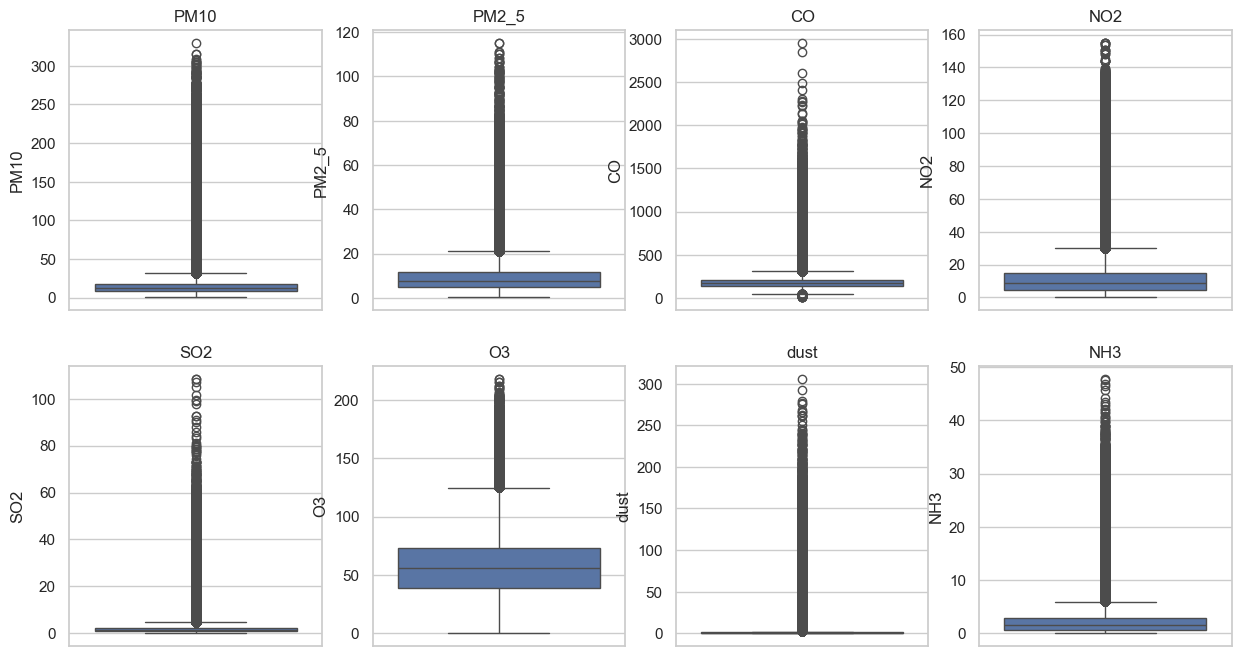

In [ ]:
columns_to_plot = ['PM10', 'PM2_5', 'CO', 'NO2', 'SO2', 'O3', 'dust', 'NH3']

sns.set(style="whitegrid")

plt.figure(figsize=(15, 8))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df_quality[col])
    plt.title(f'{col}')
plt.show()

Boxplots показывают множество выбросов. Необходимо ответить на вопросы:

1) Действительно процент выбросов большой?

2) С чем они связаны?

Выбросы — это значения, которые находятся дальше, чем 3 стандартных отклонения от среднего. Создадим функцию по их отбору с помощью метода Z-оценки.

In [ ]:
def find_outliers_zscore(df, value_cols, threshold=3):

    z_scores = df[value_cols].apply(zscore)     # Z-оценки
    outliers_mask = z_scores.abs() > threshold  # Маска выбросов
    outlier_rows = df[outliers_mask.any(axis=1)].copy() # Отбираем строки с выбросами

    # Добавляем колонку с названиями столбцов, которые стали выбросами
    outlier_rows["outlier_columns"] = outliers_mask.apply(
        lambda row: ', '.join(row.index[row]), axis=1
    )

    return outlier_rows

In [ ]:
value_cols = ['PM10', 'PM2_5', 'CO', 'NO2', 'SO2', 'O3', 'dust', 'NH3']
df_quality_outliers = find_outliers_zscore(df_quality, value_cols)
df_quality_outliers.head()

,date,year,country,city,latitude,longitude,PM10,PM2_5,CO,NO2,SO2,O3,dust,NH3,outlier_columns
2,2020-01-01 02:00:00+00:00,2020,Германия,Берлин,52.52,13.41,57.8,37.2,205.0,27.5,1.9,27.0,0.0,0.2,"PM10, PM2_5"
3,2020-01-01 03:00:00+00:00,2020,Германия,Берлин,52.52,13.41,50.4,30.8,201.0,23.5,1.7,28.0,0.0,0.3,"PM10, PM2_5"
19,2020-01-01 19:00:00+00:00,2020,Германия,Берлин,52.52,13.41,25.5,18.9,296.0,42.9,3.0,6.0,0.0,1.3,NO2
21,2020-01-01 21:00:00+00:00,2020,Германия,Берлин,52.52,13.41,28.3,22.9,275.0,42.0,2.9,13.0,0.0,1.1,NO2
39,2020-01-02 15:00:00+00:00,2020,Германия,Берлин,52.52,13.41,21.1,15.0,318.0,50.6,2.7,9.0,0.0,1.3,NO2


In [ ]:
# Процент выбросов от общего кол-ва строк
round(df_quality_outliers.shape[0] / df_quality.shape[0] * 100, 2)

8.81

In [ ]:
df_quality_outliers.query('city == "Берлин"')

,date,year,country,city,latitude,longitude,PM10,PM2_5,CO,NO2,SO2,O3,dust,NH3,outlier_columns
2,2020-01-01 02:00:00+00:00,2020,Германия,Берлин,52.52,13.41,57.8,37.2,205.0,27.5,1.9,27.0,0.0,0.2,"PM10, PM2_5"
3,2020-01-01 03:00:00+00:00,2020,Германия,Берлин,52.52,13.41,50.4,30.8,201.0,23.5,1.7,28.0,0.0,0.3,"PM10, PM2_5"
19,2020-01-01 19:00:00+00:00,2020,Германия,Берлин,52.52,13.41,25.5,18.9,296.0,42.9,3.0,6.0,0.0,1.3,NO2
21,2020-01-01 21:00:00+00:00,2020,Германия,Берлин,52.52,13.41,28.3,22.9,275.0,42.0,2.9,13.0,0.0,1.1,NO2
39,2020-01-02 15:00:00+00:00,2020,Германия,Берлин,52.52,13.41,21.1,15.0,318.0,50.6,2.7,9.0,0.0,1.3,NO2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43790,2024-12-29 14:00:00+00:00,2024,Германия,Берлин,52.52,13.41,30.8,30.0,339.0,25.8,2.2,18.0,0.0,0.2,PM2_5
43791,2024-12-29 15:00:00+00:00,2024,Германия,Берлин,52.52,13.41,31.2,27.7,338.0,29.5,2.1,17.0,0.0,0.2,PM2_5
43792,2024-12-29 16:00:00+00:00,2024,Германия,Берлин,52.52,13.41,30.8,27.5,341.0,34.4,1.9,16.0,0.0,0.4,PM2_5
43793,2024-12-29 17:00:00+00:00,2024,Германия,Берлин,52.52,13.41,30.3,27.3,325.0,37.0,2.2,15.0,0.0,0.4,PM2_5


In [ ]:
df_quality_outliers.city.value_counts()

city
Авилес        24001
Динслакена    20494
Пирей         17916
Ботроп        17867
Гладбек       17867
              ...  
Оденсе          476
Хорсенс         437
Ольборг         420
Эсбьерг         283
Орхус           238
Name: count, Length: 352, dtype: int64

In [ ]:
df_quality_outliers.year.value_counts()

year
2021    302995
2024    302532
2023    272882
2022    252921
2020    227998
Name: count, dtype: int64

In [ ]:
df_quality_outliers.date.nunique()

42922

Выбросы распределены равномерно и связаны с повышенным загрязнением в некоторые дни. Эти выбросы могут указывать на реальные экстремальные события, такие как резкие скачки концентрации загрязняющих веществ (например, из-за промышленных аварий, лесных пожаров, транспортных заторов или природных явлений). Также, обработка выбросов повлияет на определение индекса и сгладит результаты, поэтому было принято решение не удалять/заменять их.

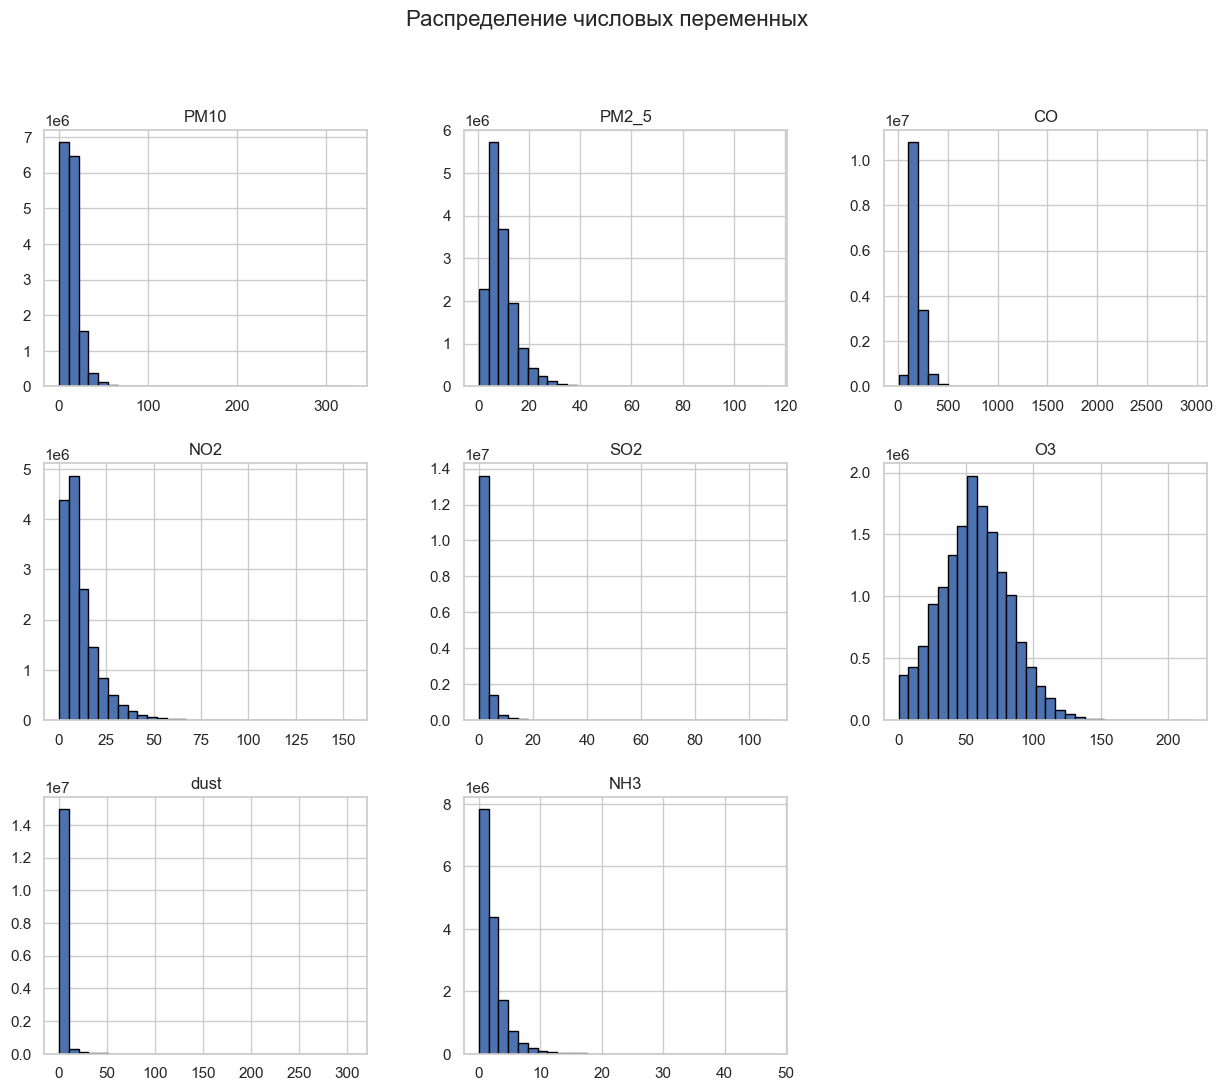

In [ ]:
df_quality[['PM10', 'PM2_5', 'CO', 'NO2', 'SO2', 'O3', 'dust', 'NH3']].hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.suptitle("Распределение числовых переменных", fontsize=16)
plt.show()

In [ ]:
del df_quality
del df_quality_outliers

### Анализ аллергенов
После обработки основных показателей для последующего анализа качества воздуха можем перейти к дополнительным условиям.

In [ ]:
df_pollen = df[['date', 'year', 'month_n', 'month', 'season', 'time_of_day',
                'country', 'city', 'latitude', 'longitude'] + df.filter(regex='.*_pollen$').columns.tolist()]
df_pollen.head()

,date,year,month_n,month,season,time_of_day,country,city,latitude,longitude,alder_pollen,birch_pollen,grass_pollen,mugwort_pollen,olive_pollen,ragweed_pollen
0,2020-01-01 00:00:00+00:00,2020,1,Январь,Зима,Ночь,Германия,Берлин,52.52,13.41,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 01:00:00+00:00,2020,1,Январь,Зима,Ночь,Германия,Берлин,52.52,13.41,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 02:00:00+00:00,2020,1,Январь,Зима,Ночь,Германия,Берлин,52.52,13.41,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01 03:00:00+00:00,2020,1,Январь,Зима,Ночь,Германия,Берлин,52.52,13.41,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01 04:00:00+00:00,2020,1,Январь,Зима,Ночь,Германия,Берлин,52.52,13.41,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_pollen_null = df_pollen.filter(regex='.*_pollen$').isnull().sum().reset_index().rename(columns={'index':'column', 0:'cnt_isnull'})
df_pollen_null['percent_isnull'] = round(df_pollen_null['cnt_isnull'] / df_pollen.shape[0] * 100, 2)
df_pollen_null

,column,cnt_isnull,percent_isnull
0,alder_pollen,7070631,45.81
1,birch_pollen,6867872,44.50
2,grass_pollen,6082208,39.41
3,mugwort_pollen,8160416,52.87
4,olive_pollen,6656690,43.13
5,ragweed_pollen,6090656,39.46


In [ ]:
df_pollen.groupby('year').apply(lambda x: x.filter(regex='.*_pollen$').isna().sum())

C:\Users\Smekh\AppData\Local\Temp\ipykernel_6212\1628183065.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pollen.groupby('year').apply(lambda x: x.filter(regex='.*_pollen$').isna().sum())


,alder_pollen,birch_pollen,grass_pollen,mugwort_pollen,olive_pollen,ragweed_pollen
year,,,,,,
2020,2779392,2365440,2365440,3091968,2365440,2365440
2021,1554432,1292544,1030656,1858560,1554439,515328
2022,1554432,1790976,1529088,1790976,1554432,1790976
2023,1182368,1418912,1157024,1418912,1182375,1418912
2024,7,0,0,0,4,0


In [ ]:
# Функция для подсчёта не пустых и не равных нулю значений
def count_non_zero_non_null(column):
    return column.notna() & (column != 0)

In [ ]:
df_pollen.groupby(['year','season','month']).apply(lambda x: x.filter(regex='.*_pollen$').apply(count_non_zero_non_null).sum())

C:\Users\Smekh\AppData\Local\Temp\ipykernel_6212\187814718.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pollen.groupby(['year','season','month']).apply(lambda x: x.filter(regex='.*_pollen$').apply(count_non_zero_non_null).sum())


alder_pollen  birch_pollen  grass_pollen  \
year season month                                                
2020 Весна  Апрель               0             0             0   
            Май                  0             0             0   
            Март                 0             0             0   
     Зима   Декабрь              0             0             0   
            Февраль              0             0             0   
            Январь               0             0             0   
     Лето   Август               0             0             0   
            Июль                 0             0             0   
            Июнь                 0             0             0   
     Осень  Ноябрь               0             0           528   
            Октябрь              0             0          8098   
            Сентябрь             0             0             0   
2021 Весна  Апрель           54588        178926        179039   
            Май              58879        176731        250427   
            Март             67137         32743         55229   
     Зима   Декабрь              0             0             0   
            Февраль          54510             0          5651   
            Январь            2575             0             0   
     Лето   Август               0             0        237047   
            Июль                 0          8124        250186   
            Июнь              5150        115345        249037   
     Осень  Ноябрь               0             0             0   
            Октябрь              0             0             0   
            Сентябрь             0             0             0   
2022 Весна  Апрель           67426        193374        191085   
            Май              18395        143167        255117   
            Март             69915         45023         74601   
     Зима   Декабрь              0             0             0   
            Февраль          77208             0             0   
            Январь           10608             0             0   
     Лето   Август               0             0        252046   
            Июль                 0           858        259183   
            Июнь               306         44526        250121   
     Осень  Ноябрь               0             0             0   
            Октябрь              0             0             0   
            Сентябрь             0             0             0   
2023 Весна  Апрель           69300        193498        199855   
            Май              16036        158029        250682   
            Март            136503         77025         90055   
     Зима   Декабрь              0             0          1030   
            Февраль         116184             0             0   
            Январь           55611             0             0   
     Лето   Август               0            14        244308   
            Июль                 0          4698        255122   
            Июнь               507         94417        251102   
     Осень  Ноябрь               0             0           909   
            Октябрь              0             0             0   
            Сентябрь             0             0         18218   
2024 Весна  Апрель           23904        193690        217606   
            Май               1428        107251        254883   
            Март             73400         89820         91915   
     Зима   Декабрь              0             0            23   
            Февраль         133488             0         27151   
            Январь           52390             0           876   
     Лето   Август               0            30        254168   
            Июль                 0          3177        258094   
            Июнь               125         23872        251056   
     Осень  Ноябрь               0             0          2620   
            Октябрь              0             0         33470

Данные по аллергенам начали отслеживаться в конце 2020 года. Также, можем заметить сезонность данных показателей, осенью и зимой показателей меньше или они = 0 (поскольку в эти времена года цветений нет).

С 2024 года все пропуски = 0 (отсутствие данных заполнялось 0), поэтому все пропуски 2021-2023 (когда подсчеты велись) заполним 0. После чего восстановим данные 2020 года для каждого города, заполнив их средними значениями соответствующих месяцев.

In [ ]:
pollen_columns = ['alder_pollen', 'birch_pollen', 'grass_pollen', 'mugwort_pollen', 'olive_pollen', 'ragweed_pollen']
df_pollen.loc[df_pollen['year'] > 2020, pollen_columns] = df_pollen.loc[df_pollen['year'] > 2020, pollen_columns].fillna(0)

In [ ]:
mean_values = df_pollen[df_pollen['year'] > 2020].groupby(['city', 'month_n'])[pollen_columns].mean()

# Заполняем пропуски в 2020 году средними значениями в разрезе город и месяц (за 2021-2024 гг)
for col in pollen_columns:
    df_pollen.loc[df['year'] == 2020, col] = df_pollen[df_pollen['year'] == 2020].apply(
        lambda row: mean_values.loc[(row['city'], row['month_n']), col]
        if (row['city'], row['month_n']) in mean_values.index else row[col], axis=1
    )

df_pollen.isna().sum()

date              0
year              0
month_n           0
month             0
season            0
time_of_day       0
country           0
city              0
latitude          0
longitude         0
alder_pollen      0
birch_pollen      0
grass_pollen      0
mugwort_pollen    0
olive_pollen      0
ragweed_pollen    0
dtype: int64

In [ ]:
df.update(df_pollen)

In [ ]:
del df_pollen_null
del df_pollen

### Анализ погодных показателей

In [ ]:
df_temp = df[['date', 'year', 'season', 'month_n', 'month', 'time_of_day', 'hour',
              'country', 'city', 'latitude', 'longitude',
              'temperature', 'temperature_ap', 'precipitation', 'wind_speed', 'wind_direction']]
df_temp.head()

,date,year,season,month_n,month,time_of_day,hour,country,city,latitude,longitude,temperature,temperature_ap,precipitation,wind_speed,wind_direction
0,2020-01-01 00:00:00+00:00,2020,Зима,1,Январь,Ночь,0,Германия,Берлин,52.52,13.41,2.1085,-1.317814,0.0,10.308831,282.09473
1,2020-01-01 01:00:00+00:00,2020,Зима,1,Январь,Ночь,1,Германия,Берлин,52.52,13.41,1.8085,-1.758666,0.0,11.159999,270.00000
2,2020-01-01 02:00:00+00:00,2020,Зима,1,Январь,Ночь,2,Германия,Берлин,52.52,13.41,1.2085,-2.283353,0.0,10.137692,276.11542
3,2020-01-01 03:00:00+00:00,2020,Зима,1,Январь,Ночь,3,Германия,Берлин,52.52,13.41,0.3585,-3.139605,0.0,9.422101,276.58185
4,2020-01-01 04:00:00+00:00,2020,Зима,1,Январь,Ночь,4,Германия,Берлин,52.52,13.41,-0.0415,-3.608093,0.0,9.422101,276.58185


In [ ]:
# Нет пропусков
df_temp.isnull().sum().sum()

0

In [ ]:
df_temp[['temperature', 'temperature_ap', 'precipitation', 'wind_speed', 'wind_direction']].describe().round(2)

,temperature,temperature_ap,precipitation,wind_speed,wind_direction
count,15434496.00,15434496.00,15434496.00,15434496.00,15434496.00
mean,13.32,11.48,0.09,11.39,191.03
std,8.07,9.60,0.41,6.85,97.35
min,-21.27,-26.00,0.00,0.00,0.36
25%,7.38,4.12,0.00,6.29,107.72
50%,13.13,11.23,0.00,9.93,209.17
75%,18.81,18.27,0.00,15.22,265.43
max,46.72,47.34,28.40,73.91,360.00


Показатели загрязнения 'temperature', 'temperature_ap', 'precipitation', 'wind_speed', 'wind_direction' - числовые непрерывные переменные.

Диапазоны значений:

    temperature     (-21.27) - 46.72
    temperature_ap     (-26) - 47.34
    precipitation          0 - 28.4
    wind_speed             0 - 73.91
    wind_direction      0.36 - 360

Ошибок в данных нет, все значения соответствуют здравому смыслу.

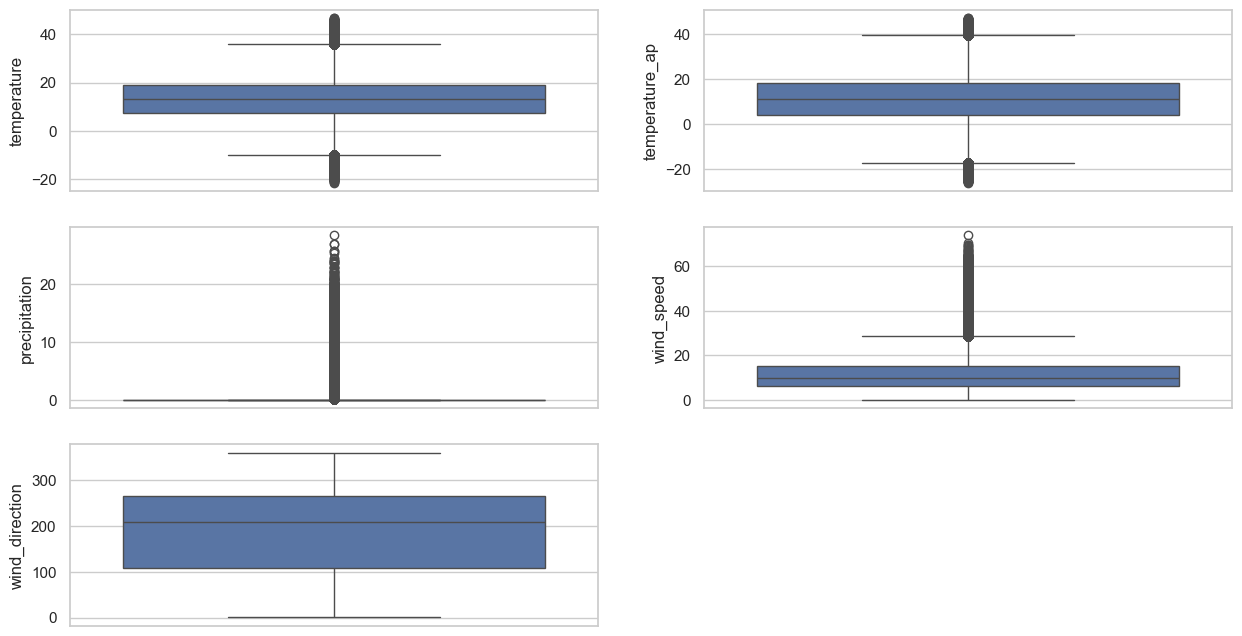

In [ ]:
columns_to_plot = ['temperature', 'temperature_ap', 'precipitation', 'wind_speed', 'wind_direction']

plt.figure(figsize=(15, 8))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=df_temp[col])
plt.show()

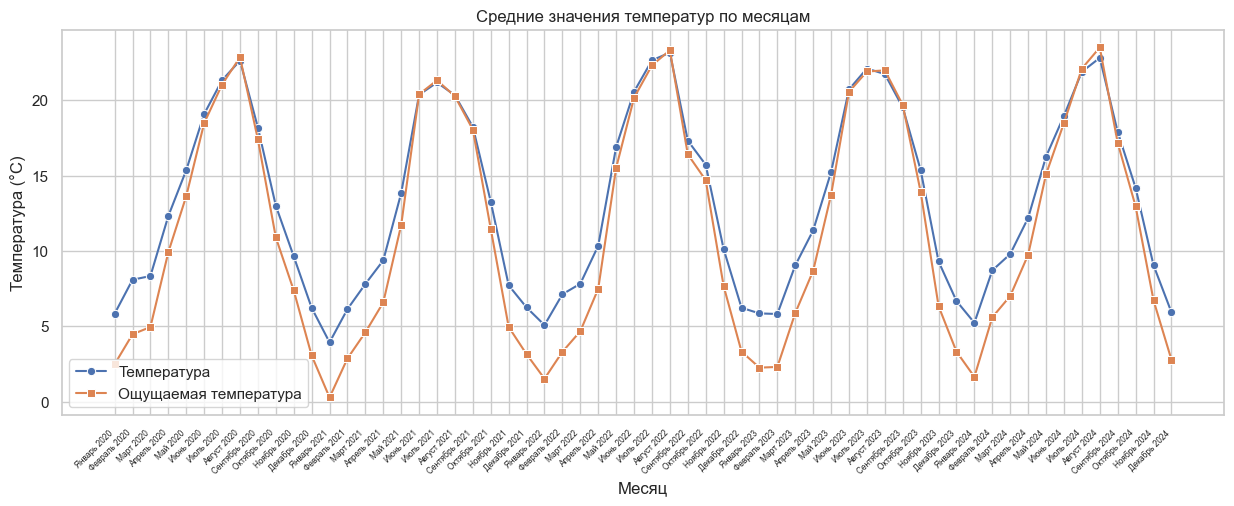

In [ ]:
# Создаем колонку с месяцем и годом
df_temp_avg = df_temp.groupby(['year', 'month', 'month_n'], as_index=False)[['temperature', 'temperature_ap']].mean()
df_temp_avg['month_year'] = df_temp_avg['month'] + ' ' + df_temp_avg['year'].astype(str)

# Сортируем по году и номеру месяца
df_temp_avg = df_temp_avg.sort_values(by=['year', 'month_n'])

plt.figure(figsize=(15, 5))
sns.lineplot(data=df_temp_avg, x='month_year', y='temperature', marker='o', label='Температура')
sns.lineplot(data=df_temp_avg, x='month_year', y='temperature_ap', marker='s', label='Ощущаемая температура')

plt.xlabel('Месяц')
plt.ylabel('Температура (°C)')
plt.title('Средние значения температур по месяцам')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45, ha='right', fontsize=6)

# Показываем график
plt.show()

del df_temp_avg

Прослеживается характерная сезонность, повышение температуры летом, снижение зимой.

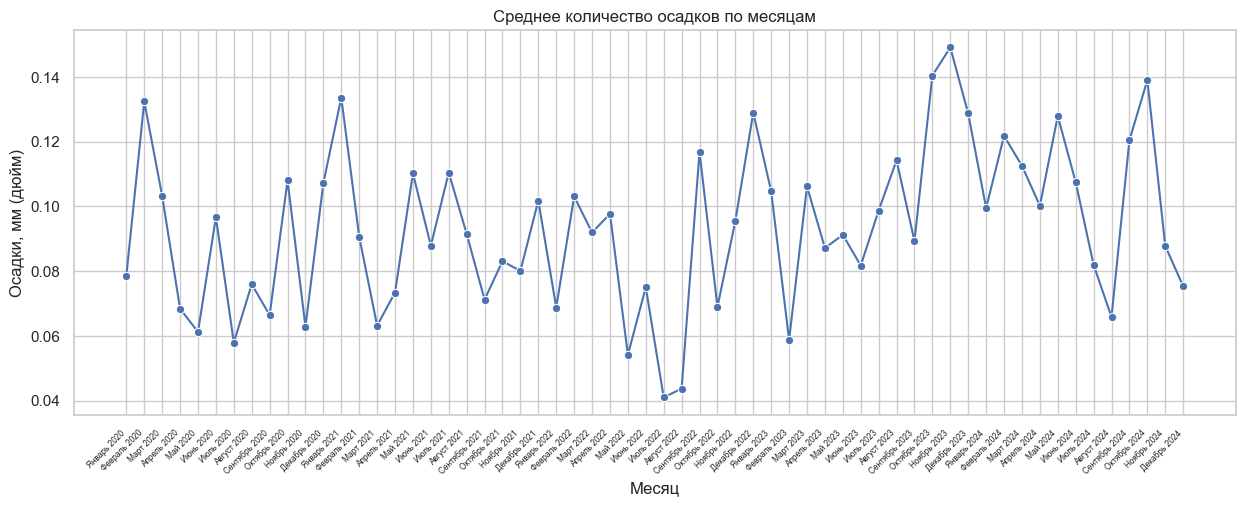

In [ ]:
# Создаем колонку с месяцем и годом
df_temp_avg = df_temp.groupby(['year', 'month', 'month_n'], as_index=False).precipitation.mean()
df_temp_avg['month_year'] = df_temp_avg['month'] + ' ' + df_temp_avg['year'].astype(str)

# Сортируем по году и номеру месяца
df_temp_avg = df_temp_avg.sort_values(by=['year', 'month_n'])

plt.figure(figsize=(15, 5))
sns.lineplot(data=df_temp_avg, x='month_year', y='precipitation', marker='o')

plt.xlabel('Месяц')
plt.ylabel('Осадки, мм (дюйм)')
plt.title('Среднее количество осадков по месяцам')
plt.grid(True)

plt.xticks(rotation=45, ha='right', fontsize=6)

# Показываем график
plt.show()

del df_temp_avg

График не показывает критичных аномалий. Однако в 2022 году их было заметно меньше, что связано с аномальной жарой в Европе в этот период. Эти данные подтверждают новостные каналы Европы.

## Анализ зависимостей
После того, как были изучены каждые переменные, необходимо выявить зависимости между ними. Для этого используем корреляционная матрицу, где коэффициент корреляция Пирсона измеряется по шкале от -1 до 1.

     0 - отсутствие линейной связи;
     1 - сильная положительная линейная связь;
    -1 - сильная отрицательная линейная связь.

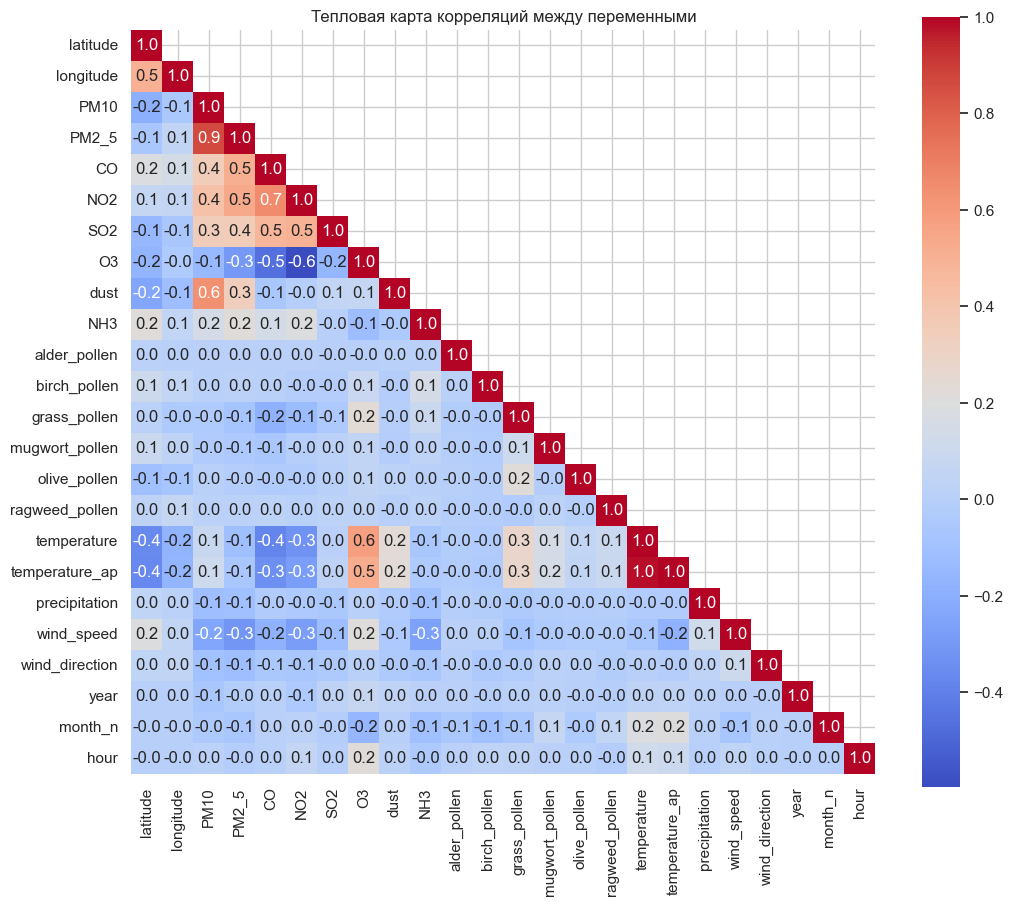

In [ ]:
correlation_matrix = df.corr(numeric_only=True)

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Тепловая карта корреляций
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", square=True, mask=mask)
plt.title('Тепловая карта корреляций между переменными', fontsize=12)
plt.yticks(rotation=0)
plt.show()

### Выводы


Объяснение некоторых корреляций

#### Сильная положительная линейная связь:
- temperature и temperature_ap (1)
  
Поскольку ощущение температуры связано с самой температурой.
- Pm2.5 и Pm10 (0,9)

Что неудивительно, посколько это одни и те же частицы, но разных диаметров. PM - это смесь мелких твёрдых частиц пыли, золы, сажи, дыма, а также соединений минерального или органического происхождения.

- Pm2.5 и dust (0.3) или Pm10 и dust (0,6)

Частицы сахарской пыли и PM взаимосвязаны, так как пыль пустыни, переносимая на большие расстояния, усиливает опасность местного загрязнения воздуха.

- O3 (озон) и temperature (0.6) или O3 (озон) и temperature_ap (0.5)

Озон в воздухе связан с температурой воздуха следующим образом: при увеличении концентрации озона происходит увеличение температуры, так как он препятствует продвижению тёплого воздуха вверх. Уменьшение концентрации озона приводит к понижению температуры атмосферного воздуха.

Также повышение температуры окружающей среды способствует синтезу и накоплению озона в атмосфере. Скорость многих химических реакций увеличивается с повышением температуры и приводит к увеличению производства озона.

- NO2 и SO2 (0.5)

Концентрация диоксида азота NO2 довольно сильно зависит от диоксида серы SO2. При сжигании ископаемого топлива, особенно угля и нефти, образуются оба газа. Кроме того, эти оба газа выделяются на электростанциях, в промышленных процессах и при работе автомобилей

#### Сильная отрицательная линейная связь

- Аллергены и месяцы

Чем больше месяц (ближе к зиме), тем меньше аллергенов.

- wind_speed_10m и PM2.5 (-0.42)

Высокая скорость ветра обычно способствует рассеиванию загрязняющих веществ

- wind_speed_10m и ozone (-0.36)

Сильный ветер может разрушать скопления озона. grass_pollen и temperature_2m (-0.33) — возможно, связано с сезонными факторами.


## Анализ качества воздуха
Для оценки качества воздуха используем индекс качества воздуха (AQI). В разных странах используют собственный AQI, который соответствует национальным стандартам качества воздуха. Поскольку в датасете представлены Европейские страны, будет использован Европейский индекс качества воздуха (European Air Quality Index), который разработан Европейским агентством по окружающей среде (EAA) в ноябре 2017 года.

Качество воздуха определяется по диапазонам EAQI:
- 0–20: Очень хорошее качество воздуха (good)
- 20–40: Хорошее качество воздуха (fair)
- 40-60: Умеренное загрязнение (moderate)
- 60-80: Плохое качество воздуха (poor)
- 80-100: Очень плохое качество воздуха (very poor)
- более 100: Чрезвычайно плохое качество воздуха (extremely poor)

Данный индекс основан на значениях концентрации пяти основных загрязнителях:
- твердые частицы (PM10);
- твердые частицы (PM2,5);
- озон (O3);
- диоксид азота (NO2);
- диоксид серы (SO2).


Пороговые значения содержания загрязняющих веществ в мкг/м3, установленные EAA, приведены в таблице (<=x<). Для определения твердых частиц используется среднее значение за 24 часа до, в то время как для газов используются почасовые значения:


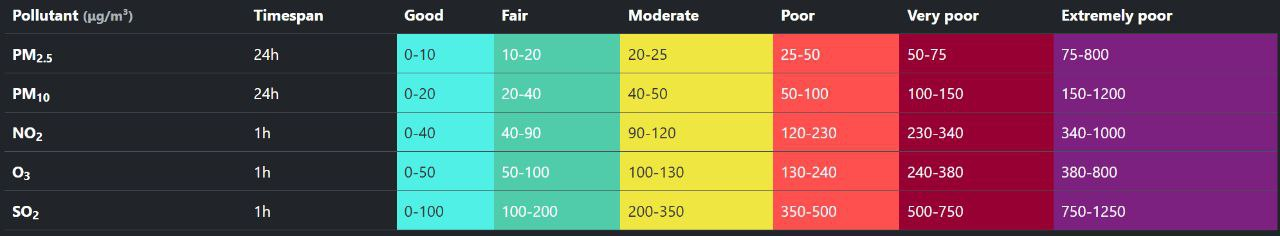

Общий же индекс качества соответствует самому наихудшему субиндексу из пяти загрязняющих веществ. Формула для субиндексов:

Ip = (y_max – y_min / x – x_min) * (x_max – x_min) + y_min где,

    x - концентрация загрязняющего вещества
    x_max - верхняя граница диапазона, в который попал х (не вкл)
    x_min - нижняя граница диапазона, в который попал х (вкл)
    y_max - верхняя граница диапазона EAQI, соответствующего x
    y_min - нижняя граница диапазона EAQI, соответствующего x

In [ ]:
def eaqi(concentration, pollutant):
    # Справочник табличных значений диапазонов для расчета EAQI
    eaqi_ranges = {
        'PM2_5': [(0, 10, 0, 20), (10, 20, 20, 40), (20, 25, 40, 60), (25, 50, 60, 80), (50, 75, 80, 100), (75, 800, 100, 120)],
        'PM10':  [(0, 20, 0, 20), (20, 40, 20, 40), (40, 50, 40, 60), (50, 100, 60, 80), (100, 150, 80, 100), (150, 1200, 100, 120)],
        'NO2':   [(0, 40, 0, 20), (40, 90, 20, 40), (90, 120, 40, 60), (120, 230, 60, 80), (230, 340, 80, 100), (340, 1000, 100, 120)],
        'O3':    [(0, 50, 0, 20), (50, 100, 20, 40), (100, 130, 40, 60), (130, 240, 60, 80), (240, 380, 80, 100), (380, 800, 100, 120)],
        'SO2':   [(0, 100, 0, 20), (100, 200, 20, 40), (200, 350, 40, 60), (350, 500, 60, 80), (500, 750, 80, 100), (750, 1250, 100, 120)]
    }

    for x_min, x_max, y_min, y_max in eaqi_ranges[pollutant]:
        if x_min <= concentration <= x_max:
            EAQI = (y_max - y_min) * (concentration - x_min) / (x_max - x_min) + y_min
            return round(EAQI, 2)

In [ ]:
def rolling_average(df, pollutant):
    # Сортируем по городу и дате, чтобы обеспечить правильный порядок
    df = df.sort_values(by=['city', 'date'])

    # Скользящее среднее за последние 24 часа
    df.set_index('date', inplace=True)
    col_name = f"{pollutant}_rolling"
    df[col_name] = df.groupby('city')[pollutant].rolling('24h', closed='left').mean().reset_index(level=0, drop=True).round(2)
    df.reset_index(inplace=True)

    return df

In [ ]:
def calculate_eaqi_for_df(df):
    pollutants = ['PM2_5', 'PM10', 'NO2', 'O3', 'SO2']

    # Рассчитываем скользящее среднее для PM2.5 и PM10
    for pollutant in pollutants:
        if pollutant in ['PM2_5', 'PM10']:
            df = rolling_average(df, pollutant)
            df[f"EAQI_{pollutant}"] = df[f"{pollutant}_rolling"].apply(lambda x: eaqi(x, pollutant) if pd.notna(x) else None)
        else:
            df[f"EAQI_{pollutant}"] = df[pollutant].apply(lambda x: eaqi(x, pollutant) if pd.notna(x) else None)

    return df

In [ ]:
df = calculate_eaqi_for_df(df)

In [ ]:
# Заполним пропуски в первых датах средними значениями (так как нет значений до)
columns_to_fill = ['PM2_5_rolling', 'EAQI_PM2_5', 'PM10_rolling', 'EAQI_PM10']

for col in columns_to_fill:
    df[col] = df.groupby(['country', 'year', 'month_n'])[col].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# Определение общего индекса качества воздуха (EAQI)
df['EAQI'] = df.filter(regex='^EAQI_').max(axis=1).round(2)

In [ ]:
# Перевод индекса в диапазоны значений
index_list = []
for key, value in df['EAQI'].items():
    if (value >= 0) & (value < 20):
       index_list.append('good')
    elif (value >= 20) & (value < 40):
       index_list.append('fair')
    elif (value >= 40) & (value < 60):
       index_list.append('moderate')
    elif (value >= 60) & (value < 80):
       index_list.append('poor')
    elif (value >= 80) & (value < 100):
       index_list.append('very poor')
    elif value >= 100:
       index_list.append('extremely poor')

df['EAQI_category'] = index_list

In [ ]:
df.head()

,date,country,city,latitude,longitude,PM10,PM2_5,CO,NO2,SO2,...,month,PM2_5_rolling,EAQI_PM2_5,PM10_rolling,EAQI_PM10,EAQI_NO2,EAQI_O3,EAQI_SO2,EAQI,EAQI_category
0,2020-01-01 00:00:00+00:00,Испания,Авила,40.66,-4.7,14.100000,10.8,141.0,16.4,1.3,...,Январь,13.171277,27.030486,19.538254,19.718966,8.20,8.8,0.26,27.03,fair
1,2020-01-01 01:00:00+00:00,Испания,Авила,40.66,-4.7,15.800000,10.7,136.0,16.4,2.1,...,Январь,10.800000,21.600000,14.100000,14.100000,8.20,8.8,0.42,21.60,fair
2,2020-01-01 02:00:00+00:00,Испания,Авила,40.66,-4.7,21.000000,13.1,151.0,16.4,2.6,...,Январь,10.750000,21.500000,14.950000,14.950000,8.20,9.2,0.52,21.50,fair
3,2020-01-01 03:00:00+00:00,Испания,Авила,40.66,-4.7,19.700001,11.5,155.0,14.0,2.0,...,Январь,11.530000,23.060000,16.970000,16.970000,7.00,9.2,0.40,23.06,fair
4,2020-01-01 04:00:00+00:00,Испания,Авила,40.66,-4.7,13.600000,10.2,155.0,12.5,1.9,...,Январь,11.530000,23.060000,17.650000,17.650000,6.25,9.6,0.38,23.06,fair


In [ ]:
df.filter(regex='^EAQI').describe().round(2)

,EAQI_PM2_5,EAQI_PM10,EAQI_NO2,EAQI_O3,EAQI_SO2,EAQI
count,15434496.00,15434496.00,15434496.00,15434496.00,15434496.00,15434496.00
mean,18.57,14.39,5.70,22.67,0.39,27.57
std,10.86,8.27,4.83,10.47,0.45,10.31
min,1.56,1.04,0.05,0.00,0.00,4.40
25%,11.14,9.00,2.40,15.60,0.16,20.56
50%,15.92,12.52,4.25,22.40,0.26,26.00
75%,22.90,17.52,7.40,29.20,0.48,32.40
max,100.19,101.80,66.36,76.00,21.70,101.80


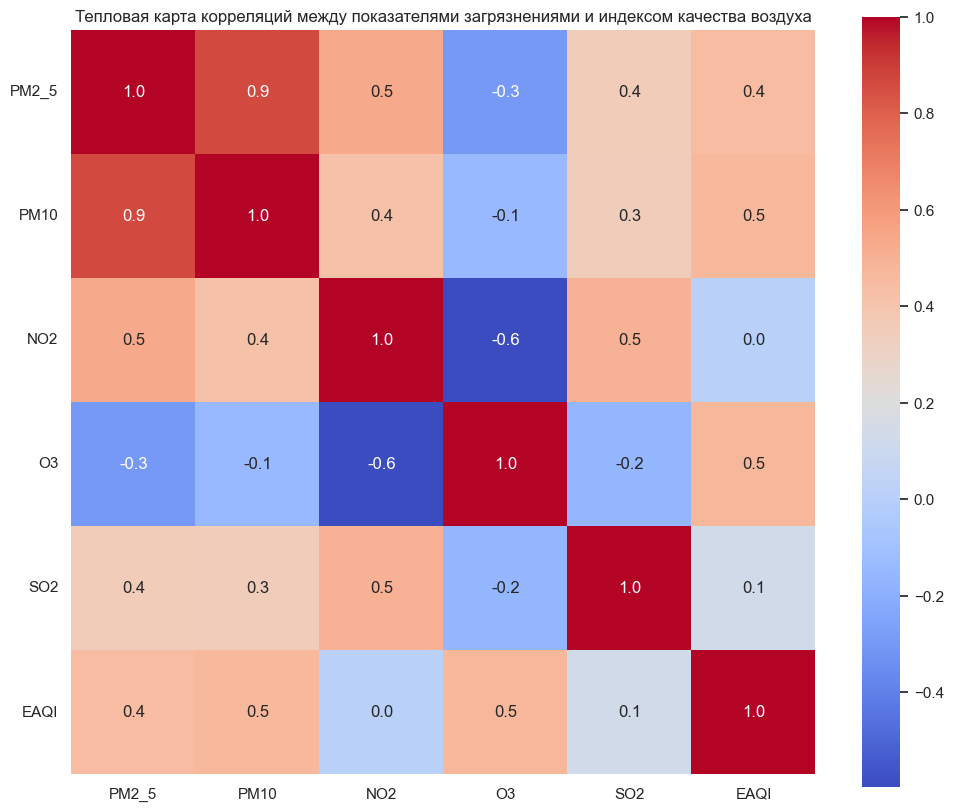

In [ ]:
correlation_matrix = df[['PM2_5', 'PM10', 'NO2', 'O3', 'SO2', 'EAQI']].corr()

# Тепловая карта корреляций
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", square=True)
plt.title('Тепловая карта корреляций между показателями загрязнениями и индексом качества воздуха', fontsize=12)
plt.yticks(rotation=0)
plt.show()

Твердые частицы больше всех остальных показателей влияютна целевую переменную. Это значит, что количество данных загрязнителей в атмосфере имеет большую долю, а они очень опасны для человека

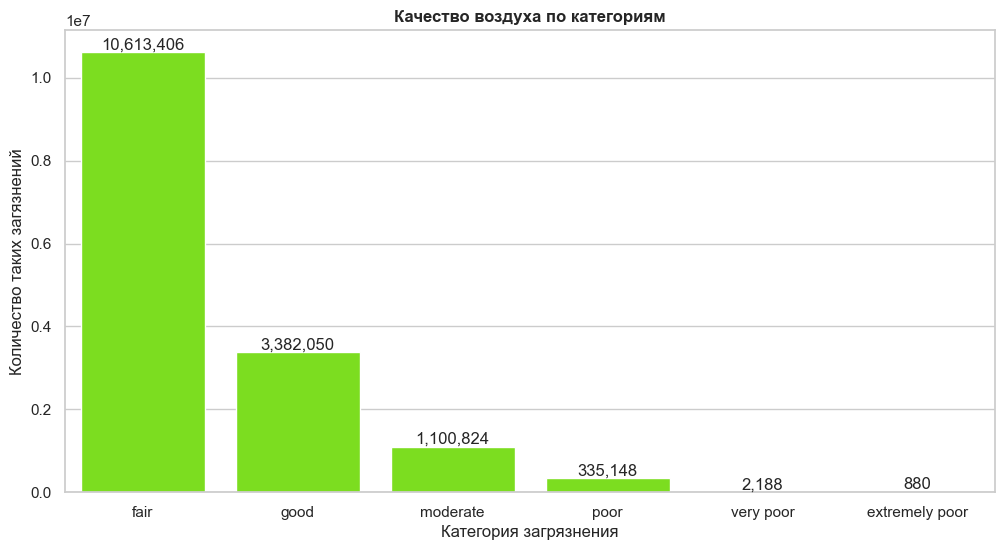

In [ ]:
caqi_counts = df['EAQI_category'].value_counts().reset_index()

plt.figure(figsize=(12, 6))

ax = sns.barplot(data=caqi_counts, x=caqi_counts['EAQI_category'], y=caqi_counts['count'], color='lawngreen')

# Добавляем подписи значений над столбиками
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2.,  # X-координата текста (центр столбика)
        p.get_height(),                  # Y-координата текста (высота столбика)
        f'{int(p.get_height()):,}',      # Текст (значение столбика с разделителями)
        ha='center',                     # Горизонтальное выравнивание (центр)
        va='bottom',                     # Вертикальное выравнивание (низ)
        fontsize=12
    )

plt.xlabel('Категория загрязнения')
plt.ylabel('Количество таких загязнений')
plt.title('Качество воздуха по категориям', fontweight='bold')
plt.show();

Если смотреть на распределение категорий, то в рассматриваемых странах преобладает хорошее качество воздуха.

In [ ]:
# Распределение критических часовых значений по странам
filtered_counts = df.query('EAQI >= 60').groupby(['country', 'EAQI_category']).EAQI.count()
filtered_counts

country    EAQI_category 
Австрия    poor               11508
           very poor              9
Германия   poor              169284
           very poor            269
Греция     extremely poor         1
           poor               27682
           very poor            222
Дания      poor                1909
Испания    extremely poor       879
           poor              114736
           very poor           1688
Швейцария  poor               10029
Name: EAQI, dtype: int64

In [ ]:
total_counts = df.groupby('country').EAQI.count()

filtered_counts = df.query('EAQI >= 60').groupby(['country']).EAQI.count()

# Объединяем данные с общим количеством строк для каждой страны
result = filtered_counts.reset_index(name='filtered_count')  # Получаем DataFrame с результатами

# Добавляем столбец с долей от общего количества строк по каждой стране
result['share'] = result.apply(lambda row: row['filtered_count'] / total_counts[row['country']], axis=1)

result

,country,filtered_count,share
0,Австрия,11517,0.037522
1,Германия,169553,0.020678
2,Греция,27905,0.035356
3,Дания,1909,0.004354
4,Испания,117303,0.022109
5,Швейцария,10029,0.025414


По доле критических значений (poor и хуже) лидирует Австрия (0.038) и Греция (0.036). Однако, стоит заметить, что это только 4% записей имеют плохие показатели и, в основном, качество воздуха хорошее или удовлетворительное.

Соберем топ-5 городов, в которых средний индекс качества воздуха за год был максимальным и минимальным. Таким образом, выявим наилучшие и наихудшие города из датасета по экологическим показателям на данный момент.

In [ ]:
# Ежегодные средние показатели индекса качества воздуха городов
cities_eaqi_avg = df.groupby(['year', 'country', 'city'], as_index=False)['EAQI'].mean()
cities_eaqi_avg

,year,country,city,EAQI
0,2020,Австрия,Вена,30.479252
1,2020,Австрия,Грац,33.102226
2,2020,Австрия,Зальцбург,28.415653
3,2020,Австрия,Инсбрук,25.297865
4,2020,Австрия,Клагенфурт,30.691885
...,...,...,...,...
1755,2024,Швейцария,Лозанна,26.461730
1756,2024,Швейцария,Лугано,28.999122
1757,2024,Швейцария,Люцерн,25.816494
1758,2024,Швейцария,Санкт-Галлен,27.331711


In [ ]:
top_10_False = cities_eaqi_avg.sort_values(['year','EAQI', 'city'], ascending=[True, False, True]).groupby('year').head(5)
top_10_False

,year,country,city,EAQI
207,2020,Греция,Салоники,35.941835
206,2020,Греция,Родос,35.266045
198,2020,Греция,Каламария,35.241101
211,2020,Греция,Ханья,34.625223
203,2020,Греция,Перистерион,33.727642
558,2021,Греция,Родос,37.409283
547,2021,Греция,Афины,37.364833
552,2021,Греция,Каллифея,37.364833
563,2021,Греция,Ханья,37.302529
555,2021,Греция,Перистерион,36.662455


In [ ]:
top_10_False['city'].value_counts()

city
Родос                       5
Ханья                       3
Перистерион                 3
Афины                       2
Руби                        2
Салоники                    1
Каламария                   1
Каллифея                    1
Пирей                       1
Петроуполис                 1
Бадалона                    1
Санта-Колома-де-Граманет    1
Барселона                   1
Грац                        1
Ираклион                    1
Name: count, dtype: int64

Худшей страной для жизни на данный момент является Греция. Поскольку она уже 5 лет занимает почти все места в топ-5 "грязных" городов. Самый грязный из них - Родос (все пять лет занимает верхние места  в топе).

In [ ]:
top_10_True = cities_eaqi_avg.sort_values(['year','EAQI', 'city'], ascending=[True, True, True]).groupby('year').head(5)
top_10_True

,year,country,city,EAQI
297,2020,Испания,Понтеведра,23.342335
294,2020,Испания,Памплона,23.552095
247,2020,Испания,Виго,23.690077
289,2020,Испания,Оренсе,23.830105
83,2020,Германия,Керпен,23.852828
435,2021,Германия,Керпен,23.938389
541,2021,Германия,Эрфтштадт,23.938409
501,2021,Германия,Тройсдорф,23.993692
491,2021,Германия,Регенсбург,24.003100
528,2021,Германия,Хюрт,24.008147


In [ ]:
top_10_True['city'].value_counts()

city
Понтеведра                3
Виго                      3
Логроньо                  3
Памплона                  2
Керпен                    2
Сантьяго-де-Компостела    2
Понферрада                2
Оренсе                    1
Эрфтштадт                 1
Тройсдорф                 1
Регенсбург                1
Хюрт                      1
Леон                      1
Инсбрук                   1
Паленсия                  1
Name: count, dtype: int64

# Проверка гипотез

### Анализ рейтингов 10 наиболее чистых и загрязнённых городов позволил выдвинуть 3 гипотезы о факторах, влияющих на качество воздуха.


Во-первых, была выявлена взаимосвязь между уровнем урбанизации и степенью загрязнения атмосферного воздуха. В топ-10 самых загрязнённых городов вошли преимущественно крупные агломерации и региональные центры, тогда как в списке самых чистых преобладают средние и малые города. Это позволило предположить, что средний индекс качества воздуха на 60% выше в городах категории «очень крупный» по сравнению с городами категории «малый» из-за большего количества близлежащих автомагистралей и автомобилей.

Во-вторых, выявлена недельная динамика индекса качества воздуха в крупных городах (с ростом в будни). Что связано с влиянием антропогенных факторов, таких как интенсивность транспортных потоков и работа промышленных предприятий.

В третьих, анализ данных о концентрации PM2.5 и метеорологических условиях показал, что скорость ветра также играет значительную роль. В городах с низкой скоростью ветра (≤ 10 м/с) средний уровень PM2.5 на 42% выше, чем в городах с высокой скоростью ветра (> 10 м/с). Это связано с тем, что слабые ветры не обеспечивают эффективного рассеивания загрязняющих веществ, приводя к их накоплению в приземном слое атмосферы.


## Гипотеза №1
Средний показатель концентрации SO2 и NO2 на 60% выше в городах категории "очень крупный", чем в городах категории "малый" за счет большего количества близлежащих автомагистралей и автомобилей.
- $H_0$: Средний уровень SO₂/NO₂ в "очень крупных" городах не отличается или не выше на 60% по сравнению с "малыми" городами.
- $H_1$: Средний уровень SO₂/NO₂ в "очень крупных" городах на 60% выше, чем в "малом" городе.

In [ ]:
# Загрузка доп данных по городам
add_data_countries = pd.read_excel('data/source/add_data_countries.xlsx', usecols=lambda x: 'Unnamed' not in x)
add_data_countries.head()

,Country,City,Year,"City_population,person",Type_prod,Category_volume_prod,Wind_rose,Location,Close_autobahn_quantity,Id_close_autobahn,Cars_on_population,Country_population,Cars_quantity,Cars_quantity_1000
0,Австрия,Вена,2020,1929940,"металлургическая, электротехническая, машиност...",очень крупный,Северный,Северо-восток,6,"A1, A2, A3, A4, A5, A19",1.103752e+06,8.9,5.09,1748.526523
1,Австрия,Вена,2021,1944910,"металлургическая, электротехническая, машиност...",очень крупный,Северный,Северо-восток,6,"A1, A2, A3, A4, A5, A20",1.108599e+06,9.0,5.13,1754.385965
2,Австрия,Вена,2022,1973403,"металлургическая, электротехническая, машиност...",очень крупный,Северный,Северо-восток,6,"A1, A2, A3, A4, A5, A21",1.116816e+06,9.1,5.15,1766.990291
3,Австрия,Вена,2023,1982097,"металлургическая, электротехническая, машиност...",очень крупный,Северный,Северо-восток,6,"A1, A2, A3, A4, A5, A21",1.128271e+06,9.1,5.18,1756.756757
4,Австрия,Вена,2024,2005760,"металлургическая, электротехническая, машиност...",очень крупный,Северный,Северо-восток,6,"A1, A2, A3, A4, A5, A21",1.148353e+06,9.1,5.21,1746.641075


In [ ]:
big_small_cities = add_data_countries[['Country','City','Year','Category_volume_prod','Close_autobahn_quantity']].copy()
big_small_cities = big_small_cities[big_small_cities['Category_volume_prod'].isin(['малый', 'очень крупный'])]
big_small_cities.head()

,Country,City,Year,Category_volume_prod,Close_autobahn_quantity
0,Австрия,Вена,2020,очень крупный,6
1,Австрия,Вена,2021,очень крупный,6
2,Австрия,Вена,2022,очень крупный,6
3,Австрия,Вена,2023,очень крупный,6
4,Австрия,Вена,2024,очень крупный,6


In [ ]:
# Проверка смены статусов
if big_small_cities.City.nunique() == big_small_cities.groupby('City').Category_volume_prod.nunique().sum() == big_small_cities.groupby('City').Close_autobahn_quantity.nunique().sum():
    print('Смены статусов и кол-ва дорог нет, можем отказаться от поля с годами')

big_small_cities = big_small_cities[['Country', 'City','Category_volume_prod','Close_autobahn_quantity']].drop_duplicates()
big_small_cities.columns = big_small_cities.columns.str.lower() #избавляемся от заглавных букв
print(big_small_cities.shape)
big_small_cities.head()

Смены статусов и кол-ва дорог нет, можем отказаться от поля с годами
(37, 4)


,country,city,category_volume_prod,close_autobahn_quantity
0,Австрия,Вена,очень крупный,6
35,Дания,Копенгаген,очень крупный,3
85,Греция,Афины,очень крупный,2
180,Швейцария,Базель,очень крупный,3
190,Швейцария,Женева,очень крупный,2


In [ ]:
df_hypothesis_1 = pd.merge(df[['date', 'year', 'country','city','SO2','NO2']], big_small_cities, on=['country', 'city'])
print(df_hypothesis_1.info())
df_hypothesis_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446984 entries, 0 to 1446983
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype              
---  ------                   --------------    -----              
 0   date                     1446984 non-null  datetime64[ns, UTC]
 1   year                     1446984 non-null  int32              
 2   country                  1446984 non-null  object             
 3   city                     1446984 non-null  object             
 4   SO2                      1446984 non-null  float64            
 5   NO2                      1446984 non-null  float64            
 6   category_volume_prod     1446984 non-null  object             
 7   close_autobahn_quantity  1446984 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(2), int32(1), int64(1), object(3)
memory usage: 82.8+ MB
None


,date,year,country,city,SO2,NO2,category_volume_prod,close_autobahn_quantity
0,2020-01-01 00:00:00+00:00,2020,Греция,Афины,9.8,29.700001,очень крупный,2
1,2020-01-01 01:00:00+00:00,2020,Греция,Афины,9.3,31.000000,очень крупный,2
2,2020-01-01 02:00:00+00:00,2020,Греция,Афины,10.2,29.500000,очень крупный,2
3,2020-01-01 03:00:00+00:00,2020,Греция,Афины,10.0,31.500000,очень крупный,2
4,2020-01-01 04:00:00+00:00,2020,Греция,Афины,8.6,32.200001,очень крупный,2


In [ ]:
mean_pollution = df_hypothesis_1.groupby('category_volume_prod')[['SO2','NO2']].mean()
display(mean_pollution)

mean_pollution_by_year = df_hypothesis_1.groupby(['category_volume_prod', 'year'])[['SO2','NO2']].mean()
mean_pollution_pivot = mean_pollution_by_year.unstack(level='year')
display(mean_pollution_pivot)

,SO2,NO2
category_volume_prod,,
малый,2.948040,13.240272
очень крупный,2.519017,15.955629


SO2                                          \
year                      2020      2021      2022      2023      2024   
category_volume_prod                                                     
малый                 2.297256  2.485588  3.118596  3.356147  3.482929   
очень крупный         2.102090  2.484920  2.608666  2.754732  2.645475   

                            NO2                                              
year                       2020       2021       2022       2023       2024  
category_volume_prod                                                         
малый                 13.707497  14.486473  13.209075  12.401410  12.397934  
очень крупный         16.344439  16.955319  14.857585  16.227319  15.393955

Показатель SO₂ стабильно растет в малых городах с 2020 по 2024 гг. В очень крупных городах показатель SO2 также растет, однако показатели данного загрянителя в малых городах всегда выше, чем в очень крупных городах. Показатель NO₂ в целом за период в очень крупных городах превышает данный показатель в малых городах, однако ни в один год разница NO₂ не достигла 60%, максимальное значение разницы зафиксировано в 2023 г. (+30.9%).Уже можно сказать о неподтверждении гипотезы.

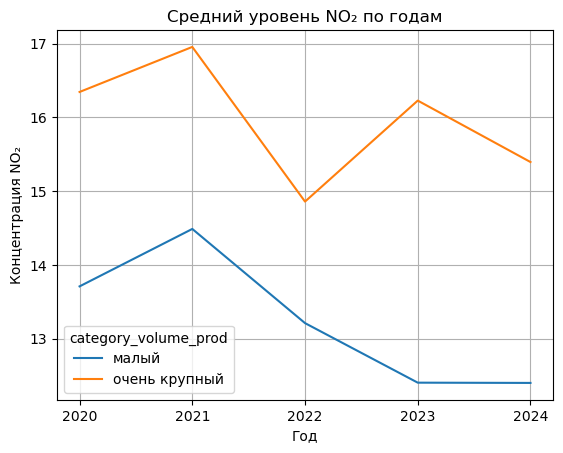

In [ ]:
import matplotlib.ticker as ticker

ax = mean_pollution_by_year.unstack(level='category_volume_prod')['NO2'].plot(
    title='Средний уровень NO₂ по годам',
    xlabel='Год',
    ylabel='Концентрация NO₂',
    grid=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

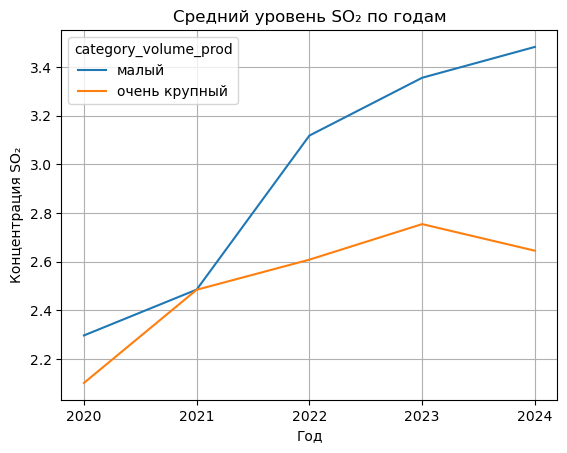

In [ ]:
ax = mean_pollution_by_year.unstack(level='category_volume_prod')['SO2'].plot(
    title='Средний уровень SO₂ по годам',
    xlabel='Год',
    ylabel='Концентрация SO₂',
    grid=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

Стабильное превышение концентраций NO₂ в очень крупных городах по сравнению с малыми на протяжении всего периода (2020-2024 гг.). Гипотеза лишь частично подтверждается: разница в пользу крупных городов сохраняется, но не достигает заявленных 60%. Крупные предприятия меньше загрязняют SO₂, но больше NO₂ по сравнению с малыми.

In [ ]:
# извлечение средних значений для каждой категории в целом за период
so2_large = mean_pollution.loc['очень крупный', 'SO2']
no2_large = mean_pollution.loc['очень крупный', 'NO2']

so2_small = mean_pollution.loc['малый', 'SO2']
no2_small = mean_pollution.loc['малый', 'NO2']

# расчёт разницы в процентах
so2_diff_percent = ((so2_large - so2_small) / so2_small) * 100
no2_diff_percent = ((no2_large - no2_small) / no2_small) * 100

print(f"Разница в SO₂: {so2_diff_percent:.1f}%")
print(f"Разница в NO₂: {no2_diff_percent:.1f}%")

Разница в SO₂: -14.6%
Разница в NO₂: 20.5%


In [ ]:
mean_pollution_by_year = mean_pollution_by_year.unstack(level='category_volume_prod')

for year in mean_pollution_by_year.index:
    # извлекаем значения для текущего года
    so2_large = mean_pollution_by_year.loc[year, ('SO2', 'очень крупный')]
    no2_large = mean_pollution_by_year.loc[year, ('NO2', 'очень крупный')]

    so2_small = mean_pollution_by_year.loc[year, ('SO2', 'малый')]
    no2_small = mean_pollution_by_year.loc[year, ('NO2', 'малый')]

    so2_diff = ((so2_large - so2_small) / so2_small) * 100 if so2_small != 0 else float('nan')
    no2_diff = ((no2_large - no2_small) / no2_small) * 100 if no2_small != 0 else float('nan')

    print(f"\nГод {year}:")
    print(f"Разница в SO₂: {so2_diff:.1f}%")
    print(f"Разница в NO₂: {no2_diff:.1f}%")


Год 2020:
Разница в SO₂: -8.5%
Разница в NO₂: 19.2%

Год 2021:
Разница в SO₂: -0.0%
Разница в NO₂: 17.0%

Год 2022:
Разница в SO₂: -16.4%
Разница в NO₂: 12.5%

Год 2023:
Разница в SO₂: -17.9%
Разница в NO₂: 30.9%

Год 2024:
Разница в SO₂: -24.0%
Разница в NO₂: 24.2%


Крупные города демонстрируют лучшие показатели по SO₂, несмотря на большую промышленную активность. Возможные причины: более строгие экологические нормы, использование очистных сооружений, замена топлива на менее сернистое.

Превышение NO₂ в крупных городах сохраняется, но с колебаниями. Пик в 2023 году (+30.9%) может быть связан с: ростом транспортной нагрузки, метеорологическими условиями, изменениями в методах измерений.

Рассматриваемые страны имеют жесткие нормы по SO2. В рассматриваемых странах есть дополнительные меры контроля:

Зоны с низким уровнем выбросов (LEZ) Во многих городах (Берлин) действуют Low Emission Zones (LEZ), где ограничен въезд автомобилей с высокими выбросами (Euro 0–4).

Есть экологические стандарты для автотранспорта (Euro 6): Euro 6d (2021):NO2: 80 mg/km (бензин), 60 mg/km (дизель). SO₂: Фактически исключен благодаря ультранизкому показателю серы в топливе (10 ppm).

Система торговли квотами (EU ETS). Промышленные предприятия должны покупать квоты на выбросы CO₂, что косвенно влияет и на SO₂ (из-за перехода на более чистые технологии).

#### Проведем проверку гипотезы с помощью статистических тестов.

In [ ]:
# Стастистика
df_hypothesis_1.groupby('category_volume_prod')['SO2'].describe()

,count,mean,std,min,25%,50%,75%,max
category_volume_prod,,,,,,,,
малый,87696.0,2.948040,3.569318,0.1,0.9,1.5,3.6,72.9
очень крупный,1359288.0,2.519017,2.512369,0.0,1.0,1.8,3.2,101.7


In [ ]:
# Статистики SO2 по годам и категориям
df_hypothesis_1.groupby(['category_volume_prod', 'year'])['SO2'].describe()

count      mean       std  min  25%  50%  75%  \
category_volume_prod year                                                     
малый                2020   17568.0  2.297256  2.623649  0.1  0.8  1.2  2.6   
                     2021   17520.0  2.485588  2.528549  0.2  0.9  1.5  3.0   
                     2022   17520.0  3.118596  3.350027  0.4  1.1  1.8  3.8   
                     2023   17520.0  3.356147  3.955669  0.2  0.9  1.7  4.2   
                     2024   17568.0  3.482929  4.735436  0.1  0.5  1.5  4.9   
очень крупный        2020  272304.0  2.102090  1.769465  0.0  0.9  1.6  2.7   
                     2021  271560.0  2.484920  2.118889  0.1  1.0  1.9  3.3   
                     2022  271560.0  2.608666  2.316764  0.1  1.2  2.0  3.2   
                     2023  271560.0  2.754732  2.416891  0.1  1.2  2.1  3.5   
                     2024  272304.0  2.645475  3.530919  0.0  0.8  1.5  3.1   

                             max  
category_volume_prod year         
малый                2020   31.0  
                     2021   28.1  
                     2022   40.4  
                     2023   43.1  
                     2024   72.9  
очень крупный        2020   35.4  
                     2021   47.6  
                     2022   50.5  
                     2023   61.0  
                     2024  101.7

In [ ]:
# Стастистика
df_hypothesis_1.groupby('category_volume_prod')['NO2'].describe()

,count,mean,std,min,25%,50%,75%,max
category_volume_prod,,,,,,,,
малый,87696.0,13.240272,9.565444,0.6,6.5,10.6,17.300000,80.300000
очень крупный,1359288.0,15.955629,11.486977,0.8,7.8,12.7,20.799999,150.600006


In [ ]:
# Статистики NO2 по годам и категориям
df_hypothesis_1.groupby(['category_volume_prod', 'year'])['NO2'].describe()

count       mean        std  min  25%   50%  \
category_volume_prod year                                                   
малый                2020   17568.0  13.707497   9.342779  1.1  7.0  11.3   
                     2021   17520.0  14.486473   9.942007  1.4  7.3  11.8   
                     2022   17520.0  13.209075   8.890284  1.1  7.1  11.0   
                     2023   17520.0  12.401410   8.457689  1.1  6.4  10.0   
                     2024   17568.0  12.397934  10.842540  0.6  4.8   8.9   
очень крупный        2020  272304.0  16.344439  11.671821  0.9  7.8  13.1   
                     2021  271560.0  16.955319  11.202362  1.1  8.8  13.9   
                     2022  271560.0  14.857585  10.130651  1.0  7.7  12.0   
                     2023  271560.0  16.227319  11.634740  1.2  8.2  12.8   
                     2024  272304.0  15.393955  12.538175  0.8  6.6  11.4   

                                 75%         max  
category_volume_prod year                         
малый                2020  18.000000   80.300000  
                     2021  18.900000   71.600000  
                     2022  16.800000   72.600000  
                     2023  16.100000   67.300000  
                     2024  16.400000   71.000000  
очень крупный        2020  21.700001  150.600006  
                     2021  22.299999  144.899994  
                     2022  19.100000  102.300003  
                     2023  20.600000  123.300003  
                     2024  20.100000  119.300003

In [ ]:
group_large = df_hypothesis_1[df_hypothesis_1['category_volume_prod'] == 'очень крупный']['SO2']
group_small = df_hypothesis_1[df_hypothesis_1['category_volume_prod'] == 'малый']['SO2']
print(shapiro(group_large))
print(shapiro(group_small))

ShapiroResult(statistic=0.6803666503893908, pvalue=1.8385097010160996e-198)
ShapiroResult(statistic=0.6665865485037902, pvalue=2.0516159854528414e-144)


C:\Users\Smekh\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1359288.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Smekh\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 87696.
  res = hypotest_fun_out(*samples, **kwds)


Распределение SO₂ значительно отклоняется от нормального в обеих категориях городов. Распределение в очень крупных городах чуть ближе к нормальному (0.680 vs 0.667), но разница несущественна. Распределение SO₂ категорически не является нормальным ни в малых, ни в очень крупных городах. Так как p-value ≪ 0.05, мы отвергаем H₀.

In [ ]:
group_large = df_hypothesis_1[df_hypothesis_1['category_volume_prod'] == 'очень крупный']['NO2']
group_small = df_hypothesis_1[df_hypothesis_1['category_volume_prod'] == 'малый']['NO2']
print(shapiro(group_large))
print(shapiro(group_small))

ShapiroResult(statistic=0.8548822201442875, pvalue=2.8073825740958676e-170)
ShapiroResult(statistic=0.8655438777094044, pvalue=1.4435099527724273e-117)


C:\Users\Smekh\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1359288.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Smekh\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 87696.
  res = hypotest_fun_out(*samples, **kwds)


Данные NO2 не распределены нормально ни в одной из групп. Гипотеза H₀ отвергается с высокой степенью достоверности (p < 0.05).

Результат теста Шапиро-Уилка (ShapiroResult) показывает, что данные распределены ненормально => проведем статистичсекий U-тест Манна-Уитни

In [ ]:
# для SO₂
print("Анализ для SO₂:")
stat, p_value = mannwhitneyu(so2_small, so2_large)
print(f"Манна-Уитни: p-value = {p_value:.4f}")

# для NO₂
no2_large = df_hypothesis_1[df_hypothesis_1['category_volume_prod'] == 'очень крупный']['NO2'].dropna()
no2_small = df_hypothesis_1[df_hypothesis_1['category_volume_prod'] == 'малый']['NO2'].dropna()

print("\nАнализ для NO₂:")
stat, p_value = mannwhitneyu(no2_small, no2_large)
print(f"Манна-Уитни: p-value = {p_value:.4f}")

Анализ для SO₂:
Манна-Уитни: p-value = 1.0000

Анализ для NO₂:
Манна-Уитни: p-value = 0.0000


#### Анализ близости автомагистралей

In [ ]:
# Анализ корреляции между количеством автомагистралей и уровнями загрязнения
corr_matrix = df_hypothesis_1[['close_autobahn_quantity', 'NO2', 'SO2']].corr()
print("Корреляционная матрица:")
corr_matrix

Корреляционная матрица:


,close_autobahn_quantity,NO2,SO2
close_autobahn_quantity,1.000000,0.142868,0.118615
NO2,0.142868,1.000000,0.492291
SO2,0.118615,0.492291,1.000000


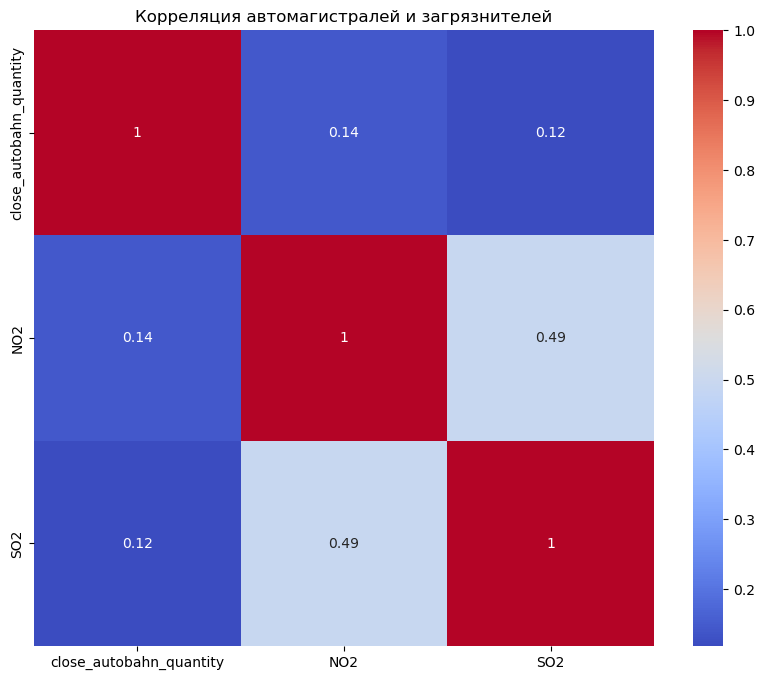

In [ ]:
# Визуализация корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляция автомагистралей и загрязнителей')
plt.show()

Корреляция пристутствует между показателями количества автомагитсралей и загрязнителей воздуха SO2 и NO2, но показатель в 0,14 и 0,12 достаочно мал, чтобы говорить о существенном влиянии именно близости автомагистралей на показатели загрязнителей.Таким образом, нипотеза не подтвердилась

In [ ]:
groups_by_year = df_hypothesis_1.groupby(['year', 'category_volume_prod'])['close_autobahn_quantity'].mean().unstack()

for year in groups_by_year.index:
    large = df_hypothesis_1[(df_hypothesis_1['year'] == year) &
                      (df_hypothesis_1['category_volume_prod'] == 'очень крупный')]['close_autobahn_quantity']
    small = df_hypothesis_1[(df_hypothesis_1['year'] == year) &
                      (df_hypothesis_1['category_volume_prod'] == 'малый')]['close_autobahn_quantity']

    # тест Манна-Уитни для сравнения групп
    stat, p_value = mannwhitneyu(large, small, alternative='greater')
    print(f"\nГод {year}:")
    print(f"Средняя разница: {large.mean() - small.mean():.1f}")
    print(f"p-value: {p_value:.4f} {'(значимо)' if p_value < 0.05 else '(не значимо)'}")


Год 2020:
Средняя разница: 0.8
p-value: 0.0000 (значимо)

Год 2021:
Средняя разница: 0.8
p-value: 0.0000 (значимо)

Год 2022:
Средняя разница: 0.8
p-value: 0.0000 (значимо)

Год 2023:
Средняя разница: 0.8
p-value: 0.0000 (значимо)

Год 2024:
Средняя разница: 0.8
p-value: 0.0000 (значимо)


Для всех годов (2020-2024) получены исключительно значимые результаты (p-value = 0.0000). Это означает, что различия в количестве автомагистралей между "очень крупными" и "малыми" городами статистически значимы на уровне p < 0.001.

Вывод: гипотеза подтвердилась частично в том, что NO2 действительно выше в очень крупных городах, чем в малых, однако разница показателей далека от 60%. В части проверки гипотезы относительно загрязнителя SO2, гипотеза не подтвердилась так как средний показатель данного загрязнителя ниже в крупных городах, что скорее всего связано с проводимыми экологическими политиками стран ЕС, строгим контролем в крупных городах за выбросами загрязнителей в воздух. Относительно влияния близости автомагистралей на разницу в средних значениях показателей SO2 и NO2 в малых и крупных городах, можно отметить, что влияние безусловно есть, но оно умеренное, однако разница в количестве автомагистралей в малых и крупных городах статистически значима.

## Гипотеза №2
Концентрация загрязняющих веществ в атмосфере возрастает/убывает в зависимости от времен года

- $H_0$: Значения EAQI в течение года не отличаются.
- $H_1$: Значения EAQI различаются в зависимости от сезона.

Делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста. Есть три категориальные переменные → нужен хи-квадрат

In [ ]:
# Предположим, что проблемы с экологией можут быть связаны с сезонами:
pd.crosstab(df.EAQI_category, df.season)

season,Весна,Зима,Лето,Осень
EAQI_category,,,,
extremely poor,880,0,0,0
fair,3086614,2567650,2625602,2333540
good,436089,915950,730405,1299606
moderate,286061,199219,460500,155044
poor,74916,135113,69544,55575
very poor,1520,564,29,75


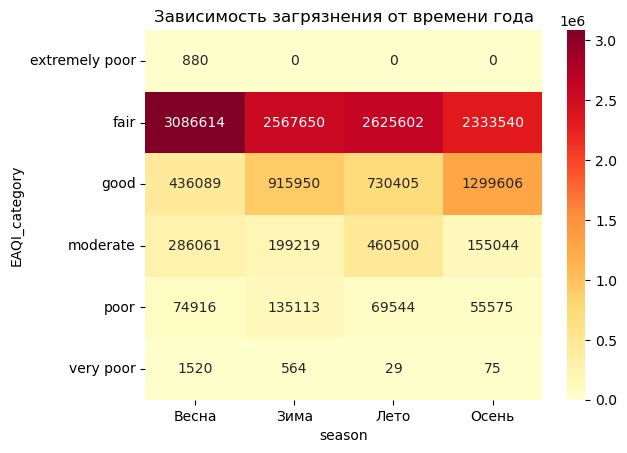

In [ ]:
sns.heatmap(pd.crosstab(df.EAQI_category, df.season), annot=True, fmt='d', cmap='YlOrRd')
plt.title("Зависимость загрязнения от времени года")
plt.show()

Из таблицы видно, что:

- "Fair" (хорошее) загрязнение доминирует во все сезоны, но его уровень колеблется:

    - Максимум зимой (2 567 650),

    - Минимум осенью (2 333 540).

- "Good" (отличное) загрязнение значительно выше осенью (1 299 606) и весной (915 950).

- "Moderate" (умеренное) и "Poor" (плохое) загрязнение чаще встречаются весной и летом.

- "Very poor" (очень плохое) и "Extremely poor" (крайне плохое) почти отсутствуют, кроме весны.

Вывод: Есть сезонные колебания, но делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста. Есть порядковые переменные, используем тест Краскела-Уоллиса. Поскольку Хи-квадрат игнорирует порядок категорий → теряет информацию

In [ ]:
# Сопоставление категорий с рангами
rank_mapping = {
    'extremely poor': 6,
    'very poor': 5,
    'poor': 4,
    'moderate': 3,
    'good': 2,
    'fair': 1
}

In [ ]:
df_hypothesis_2 = df[['season', 'EAQI_category']].copy()
df_hypothesis_2['rank'] = df_hypothesis_2['EAQI_category'].map(rank_mapping)
df_hypothesis_2.head()

,season,EAQI_category,rank
0,Зима,fair,1
1,Зима,fair,1
2,Зима,fair,1
3,Зима,fair,1
4,Зима,fair,1


In [ ]:
# Группировка по сезонам
winter = df_hypothesis_2[df_hypothesis_2['season'] == 'Зима']['rank']
spring = df_hypothesis_2[df_hypothesis_2['season'] == 'Весна']['rank']
summer = df_hypothesis_2[df_hypothesis_2['season'] == 'Лето']['rank']
autumn = df_hypothesis_2[df_hypothesis_2['season'] == 'Осень']['rank']

In [ ]:
# Тест Краскела-Уоллиса
stat, p_value = kruskal(winter, spring, summer, autumn)
print(f"Результат теста:\nstat = {stat:.2f}, p-value = {p_value:.3e}")

if p_value < 0.05:
    print("Есть статистически значимые различия между сезонами.")
else:
    print("Различия незначимы.")

Результат теста:
stat = 241973.71, p-value = 0.000e+00
Есть статистически значимые различия между сезонами.


Нулевая гипотеза отклоняется, поскольку p-value < 0.05. Значит, взаимосвязь есть. Выясним, какие именно сезоны различаются

In [ ]:
# Попарные сравнения с поправкой Бонферрони
seasons = df_hypothesis_2['season'].unique()
n_comparisons = len(list(combinations(seasons, 2)))  # Число пар
alpha_corrected = 0.05 / n_comparisons  # Поправка

for season1, season2 in combinations(seasons, 2):
    group1 = df_hypothesis_2[df_hypothesis_2['season'] == season1]['rank']
    group2 = df_hypothesis_2[df_hypothesis_2['season'] == season2]['rank']
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    print(f"{season1} vs {season2}: p-value = {p:.3f}", "-  значимые различия" if p < alpha_corrected else "")

Зима vs Весна: p-value = 0.000 -  значимые различия
Зима vs Лето: p-value = 0.000 -  значимые различия
Зима vs Осень: p-value = 0.000 -  значимые различия
Весна vs Лето: p-value = 0.000 -  значимые различия
Весна vs Осень: p-value = 0.000 -  значимые различия
Лето vs Осень: p-value = 0.000 -  значимые различия


Результаты теста Манна-Уитни с поправкой Бонферрони показывают статистически значимые различия (p < 0.05) между всеми парами сезонов по уровню загрязнения воздуха.
На основе результатов можно построить рейтинг сезонов от наихудшего к наилучшему:
1. Зима (самое высокое загрязнение)
2. Весна
3. Лето
4. Осень (самое низкое загрязнение)

## Гипотеза №3
В городах с низкой скоростью ветра (≤ 10 м/с) средний уровень PM2.5 на 42% выше, чем в городах с высокой скоростью ветра (> 10 м/с)

Разделяем наши находки в данных на гипотезы:
- $H_0$: Разница в средних значениях PM2.5 между группами одинакова.
- $H_1$: Разница в средних значениях PM2.5 между группами > 42%.

In [ ]:
df_hypothesis_3 = df[['date', 'country', 'city', 'latitude', 'longitude', 'PM2_5', 'temperature', 'temperature_ap',
                              'precipitation', 'wind_speed', 'wind_direction']]
df_low_wind = df_hypothesis_3.query("wind_speed <= 10")[['PM2_5']]
df_high_wind = df_hypothesis_3.query("wind_speed > 10")[['PM2_5']]

In [ ]:
# На сколько % среднее значение показателя РМ2.5 выше в городах с низкой скоростью ветра

def percentage_increase(df_a, df_b):
    mean_a = df_a['PM2_5'].mean()
    mean_b = df_b['PM2_5'].mean()

    percentage = (max(mean_a, mean_b) - min(mean_a, mean_b)) / min(mean_a, mean_b) * 100

    if mean_a > mean_b:
        result = "Среднее значение PM2.5 " + "\033[1m" + f"больше на {percentage:.0f}% " + "\033[0m" + "в городах с низкой скоростью ветра"
    elif mean_a == mean_b:
        result = "Среднее значение PM2.5 не отличается"
    else:
        result = "Среднее значение PM2.5 " + "\033[1m" + f"меньше на {percentage:.0f}% " + "\033[0m" + "в городах с низкой скоростью ветра"
    return result

print(percentage_increase(df_low_wind, df_high_wind))

Среднее значение PM2.5 больше на 42% в городах с низкой скоростью ветра


In [ ]:
# Расчет необходимых характеристик
low_wind = df_low_wind['PM2_5'].mean()
high_wind = df_high_wind['PM2_5'].mean()

print(f"Среднее значение PM2.5 по городам с низкой скоростью ветра: {low_wind:.2f}")
print(f"Среднее значение PM2.5 по городам с высокой скоростью ветра: {high_wind:.2f}")
print()

low_wind_var = df_low_wind['PM2_5'].var()
high_wind_var = df_high_wind['PM2_5'].var()
print(f"Дисперсия PM2.5 по городам с низкой скоростью ветра: {low_wind_var:.2f}")
print(f"Дисперсия PM2.5 по городам с высокой скоростью ветра: {high_wind_var:.2f}")
print()

low_wind_std = df_low_wind['PM2_5'].std()
high_wind_std = df_high_wind['PM2_5'].std()
print(f"Среднеквадратичное отклонение PM2.5 по городам с низкой скоростью ветра: {low_wind_std:.2f}")
print(f"Среднеквадратичное отклонение PM2.5 по городам с высокой скоростью ветра: {high_wind_std:.2f}")
print()

low_wind_median = df_low_wind['PM2_5'].median()
high_wind_median = df_high_wind['PM2_5'].median()
print(f"Медиана PM2.5 по городам с низкой скоростью ветра: {low_wind_median:.2f}")
print(f"Медиана PM2.5 по городам с высокой скоростью ветра: {high_wind_median:.2f}")

Среднее значение PM2.5 по городам с низкой скоростью ветра: 10.76
Среднее значение PM2.5 по городам с высокой скоростью ветра: 7.60

Дисперсия PM2.5 по городам с низкой скоростью ветра: 39.11
Дисперсия PM2.5 по городам с высокой скоростью ветра: 23.45

Среднеквадратичное отклонение PM2.5 по городам с низкой скоростью ветра: 6.25
Среднеквадратичное отклонение PM2.5 по городам с высокой скоростью ветра: 4.84

Медиана PM2.5 по городам с низкой скоростью ветра: 9.30
Медиана PM2.5 по городам с высокой скоростью ветра: 6.30


In [ ]:
# Проверим выборки на нормальность
print('Для низкой скорости ветра: ', normaltest(df_low_wind))
print('Для низкой скорости ветра: ', normaltest(df_high_wind))

Для низкой скорости ветра:  NormaltestResult(statistic=array([2794091.92009369]), pvalue=array([0.]))
Для низкой скорости ветра:  NormaltestResult(statistic=array([3797534.87185225]), pvalue=array([0.]))


Для обеих групп p-value = 0, что говорит о ненормальности данных.

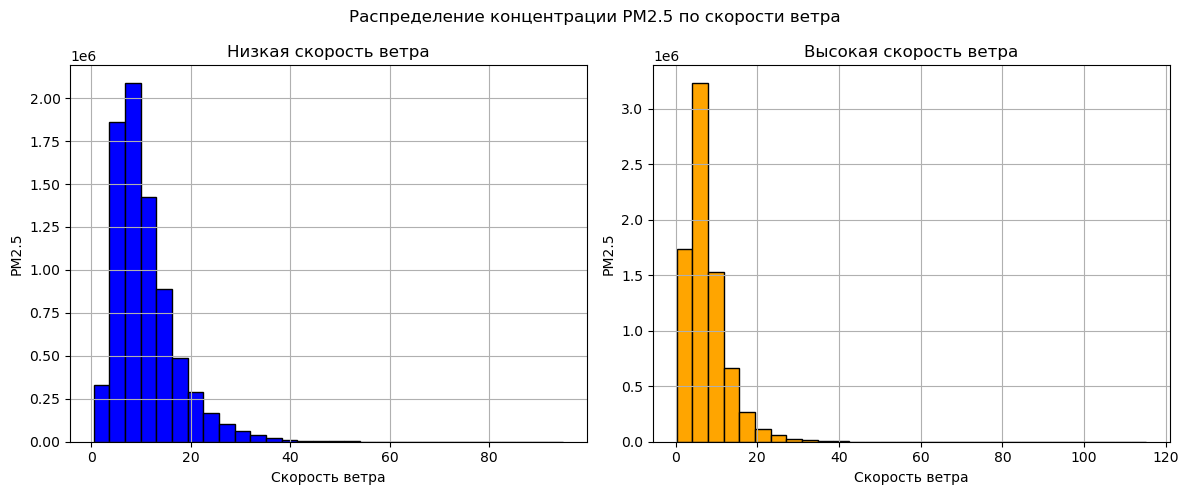

In [ ]:
# Нарисуем графики распредления, чтобы увидеть ненормальность

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Первый график (линейный)
ax1.hist(df_low_wind, color='blue', bins=30, edgecolor='black')
ax1.set_title('Низкая скорость ветра')
ax1.set_xlabel('Скорость ветра')
ax1.set_ylabel('PM2.5')
ax1.grid(True)

# Второй график (столбчатая диаграмма)
ax2.hist(df_high_wind, color='orange', bins=30, edgecolor='black')
ax2.set_title('Высокая скорость ветра')
ax2.set_xlabel('Скорость ветра')
ax2.set_ylabel('PM2.5')
ax2.grid(True)

# Настройка общего заголовка
plt.suptitle('Распределение концентрации PM2.5 по скорости ветра')

# Автоматическая подгонка расстояний
plt.tight_layout()

# Показать графики
plt.show()

Так как в наших данных:

- неравные дисперсии;
- независимые группы (разные города и разные скорости ветров)
- распределение переменной PM2.5 не является нормальным, поэтому для проверки гипотезы необходимо выбрать непараметрический U-тест (тест Манна-Уитни). Он работает именно с такими данными. Т-тест не подходит по причине ненормальности распределения данных.

In [ ]:
# Тест Манна-Уитни
stat, p_value = mannwhitneyu(df_low_wind['PM2_5'], df_high_wind['PM2_5'])
print(f"Statistics={stat:.2f}, p={p_value:.5f}")
alpha = 0.05
if p_value < alpha:
    print('Отклоняем нулевую гипотезу (Значимая разница между двумя выборками)')
else:
    print('Не отклоняем нулевую гипотезу (Не значимая разница между двумя выборками)')

Statistics=40477850826372.00, p=0.00000
Отклоняем нулевую гипотезу (Значимая разница между двумя выборками)


По результатам теста p_value < 0.05. Это значит, что нулевая гипотеза отклоняется, следовательно, принимается альтернативная. Таким образом, мы увидели значимую разницу между выборками и можно заявить, что среднее значение показателя РМ2.5 в городах с маленькой скоростью ветра выше больше чем на 42%, чем в городах с высокой скоростью ветра.

In [ ]:
# Выведем размер эффекта
n1 = df_low_wind.shape[0]
n2 = df_high_wind.shape[0]
# Вычисляем Z-оценку
mean_u = n1 * n2 / 2
sd_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
z_score = (stat.item() - mean_u) / sd_u

# Размер эффекта r
r = abs(z_score) / np.sqrt(n1 + n2)
print(f"Размер эффекта (r): {r:.3f}")

Размер эффекта (r): 0.311


### Интерпретация размера эффекта ###
По правилам Коэна:

r = 0.1 — маленький эффект,

r = 0.3 — средний эффект,

r ≥ 0.5 — большой эффект.

В нашем примере r = 0.311 — это средний эффект, что означает - Различия между группами существенны (не только статистически, но и практически).

# Построение модели. Оценка качества модели

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight

Для начала необходимо удалить из нашего общего датасета по загрязнениям ненужные для модели признаки. Так как они могут мешаться при обучении, а также вызывать высокую корреляцию с другими признаками, что повлечет за собой установку неверных весов признаков. Будем использовать только те загрязнители, что входят в формулу расчета индекса загрязнения воздуха.

Некоторые признаки мы удалим, а потом закодируем (чтобы не было строковых типов данных) - это столбцы **season, time_of_day, country, city, EAQI_category**. Так как они очень важны для предсказаний показателя загрязненности воздуха. Месяц мы уже кодировали на этапе EDA-анализа в столбце month_n.

Кодировать будем через LabelEncoder, так как он каждому значению выделяет уникальную цифру в одном столбце. OneHotEncoder в нашем случае не подойдет, так как в столбцах city, country много значений и данный енкодер создаст много новых признаков, а нам это не нужно.

In [ ]:
df_features = df[['year', 'season', 'month_n', 'time_of_day', 'country', 'city', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'EAQI_category']].copy()
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15434496 entries, 0 to 15434495
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   year           int32  
 1   season         object 
 2   month_n        int32  
 3   time_of_day    object 
 4   country        object 
 5   city           object 
 6   PM10           float64
 7   PM2_5          float64
 8   NO2            float64
 9   SO2            float64
 10  O3             float64
 11  EAQI_category  object 
dtypes: float64(5), int32(2), object(5)
memory usage: 1.3+ GB


In [ ]:
# Кодирование признаков LabelEncoder
df_features['season'] = LabelEncoder().fit_transform(df_features['season'])
df_features['time_of_day'] = LabelEncoder().fit_transform(df_features['time_of_day'])
df_features['country'] = LabelEncoder().fit_transform(df_features['country'])
df_features['city'] = LabelEncoder().fit_transform(df_features['city'])
df_features['EAQI_category'] = LabelEncoder().fit_transform(df_features['EAQI_category'])

df_features = df_features.astype(float)
df_features.head()

,year,season,month_n,time_of_day,country,city,PM10,PM2_5,NO2,SO2,O3,EAQI_category
0,2020.0,1.0,1.0,2.0,4.0,0.0,14.100000,10.8,16.4,1.3,22.0,1.0
1,2020.0,1.0,1.0,2.0,4.0,0.0,15.800000,10.7,16.4,2.1,22.0,1.0
2,2020.0,1.0,1.0,2.0,4.0,0.0,21.000000,13.1,16.4,2.6,23.0,1.0
3,2020.0,1.0,1.0,2.0,4.0,0.0,19.700001,11.5,14.0,2.0,23.0,1.0
4,2020.0,1.0,1.0,2.0,4.0,0.0,13.600000,10.2,12.5,1.9,24.0,1.0


In [ ]:
df_features.year.unique() #выведем уникальные года

array([2020., 2021., 2022., 2023., 2024.])

In [ ]:
# Разделение данных по годам
train_data = df_features[df_features['year'] < 2024]  # 2020-2023
test_data = df_features[df_features['year'] == 2024]  # для test берем 2024 год, наиболее актуальные данные, для создания прогноза на будущее

# Разделение на признаки (X) и целевую переменную (y)
X_train = train_data.drop('EAQI_category', axis=1)
y_train = train_data['EAQI_category']

X_test = test_data.drop('EAQI_category', axis=1)
y_test = test_data['EAQI_category']

# Проверка размеров
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (12342528, 11) (12342528,)
Test shape: (3091968, 11) (3091968,)


Выполним стандартизацию признаков с помощью **StandardScaler**. Это необходимо для приведения данных к единому масштабу со средним = 0 и стандартным отклонением = 1. Стандартизация на наших данных необходима, потому что мы будем обучать модель **логистической регрессии**, а она использует градиентный спуск для оптимизации. Чтобы градиентный спуск сходился не слишкомы быстро и не пропустил минимум признаки необходимо стандартизовать признаки.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # стандартизируем признаки для привидения к единому масштабу
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train) # обучаем модель логистической регрессии

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_test_pred = model.predict(X_test_scaled) # создаем предсказание тестовых данных и выводим значения метрик
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        12
         1.0       0.82      0.94      0.88   2283012
         2.0       0.69      0.48      0.57    503373
         3.0       0.60      0.17      0.26    224363
         4.0       0.59      0.29      0.39     80592
         5.0       0.00      0.00      0.00       616

    accuracy                           0.79   3091968
   macro avg       0.45      0.31      0.35   3091968
weighted avg       0.77      0.79      0.77   3091968



Отчет о классификации демонстрирует проблему дисбаланса классов в наборе данных, где класс 1.0 доминирует с 2 283 012 образцами, в то время как классы 0.0 (12 образцов) и 5.0 (616 образцов) почти не представлены.

Общая взвешенная оценка модели по метрике weighted avg составляет 77%, однако этот показатель вводит в заблуждение, поскольку отражает лишь хорошую предсказательную способность для класса 1.0, где precision достигает 0.82, recall — 0.94, а F1-score — 0.88. В то же время модель полностью игнорирует классы 0.0 и 5.0, о чем свидетельствуют нулевые метрики, а для классов 2.0, 3.0, 4.0 и демонстрирует неоднородные результаты: например, для класса 2.0 precision составляет 0.69 при recall 0.48, а для класса 3.0 при precision 0.60 recall падает до критически низких 0.17, что означает, что модель пропускает 83% случаев этого класса.  

Средние значения метрик подтверждают проблему: macro avg F1-score составляет лишь 0.35 из-за плохой работы с малыми классами, тогда как weighted avg F1-score (0.77) близок к accuracy, так как взвешен по доминирующему классу. Текущая модель практически игнорирует малые классы и является эффективной только для предсказания 1 класса, что существенно ограничивает её практическую применимость. Для улучшения модели необходимо сфокусироваться на методах борьбы с дисбалансом, в дальнейшем для решения данной проблемы применим взвешивание классов (Class Weighting), Random Forest, LGBMClassifier.

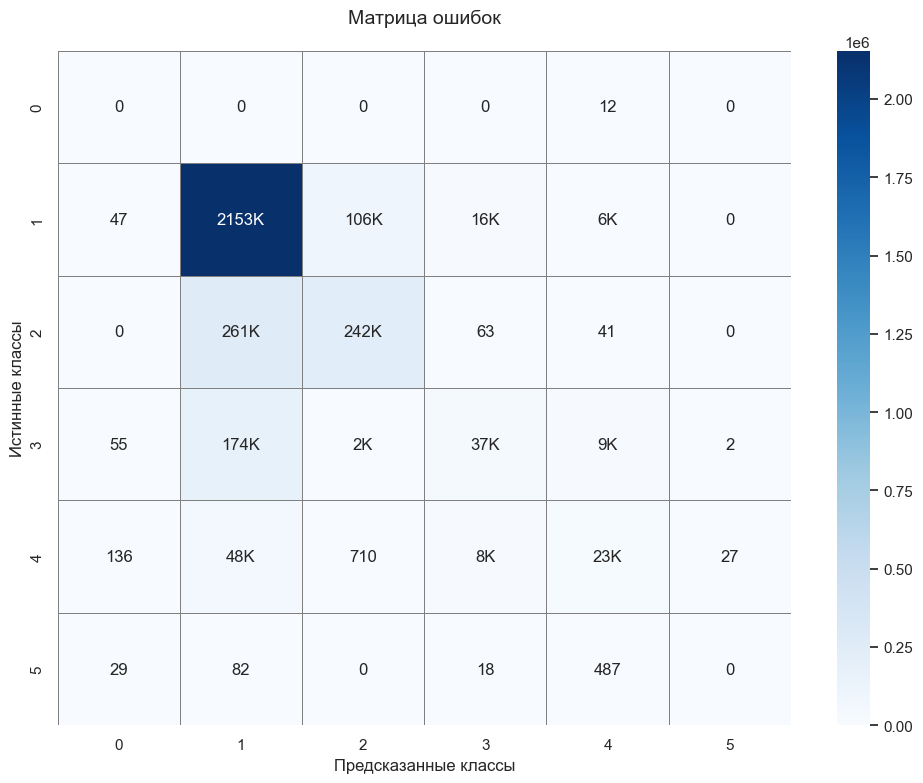

In [ ]:
# матрица ошибок
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 cbar=True, linewidths=0.5, linecolor='gray')

# Настраиваем отображение больших чисел
for t in ax.texts:
    text = t.get_text()
    if text.isdigit():  # Проверяем, является ли текст числом
        num = int(text)
        if num > 1000:
            t.set_text(f"{num//1000}K")  # Форматируем большие числа как 1K, 2K и т.д.

# Добавляем подписи
plt.title('Матрица ошибок', pad=20, fontsize=14)
plt.xlabel('Предсказанные классы', fontsize=12)
plt.ylabel('Истинные классы', fontsize=12)

plt.tight_layout()
plt.show()

Матрица ошибок подтверждает, что модель демонстрирует приемлемое общее качество (weighted avg F1=0.77), но страдает от сильного дисбаланса классов. Модель корректно предсказывает только доминирующий класс 1.0 (F1=0.88), полностью игнорируя редкие классы 0.0 и 5.0 (F1=0.00) и показывая слабые результаты для классов 2.0-4.0 (F1=0.26-0.57). Для улучшения результатов необходимо применить метод борьбы с дисбалансом (class_weight), рассмотреть ансамблевые алгоритмы.

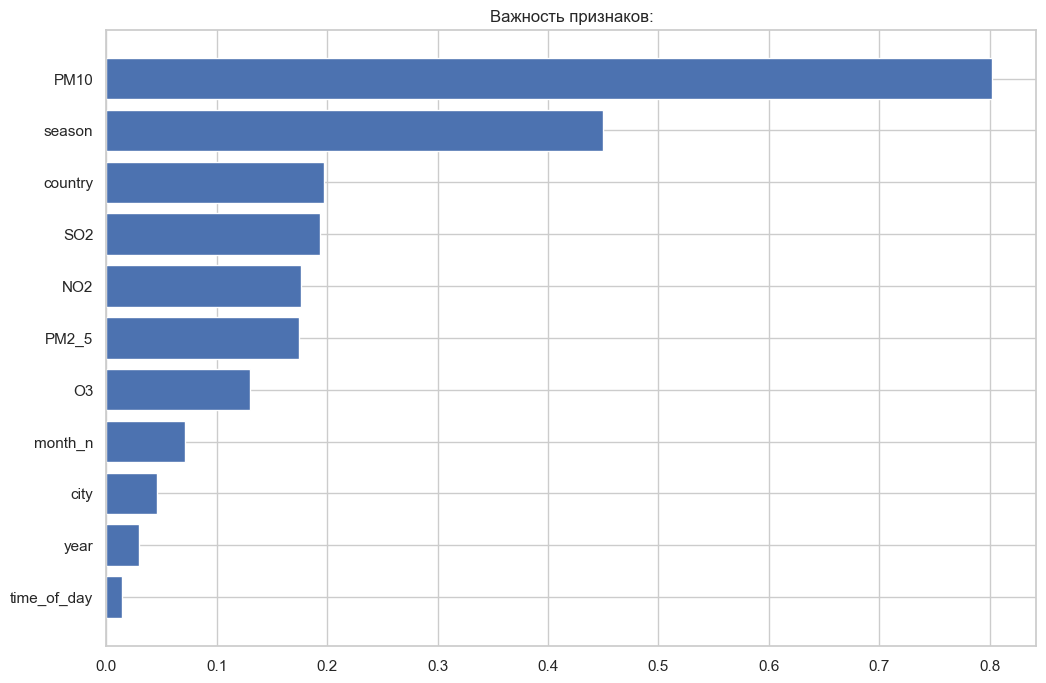

In [ ]:
# Оценка важности признаков
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(model.coef_[0])
}).sort_values('Importance')

# Визуализация
plt.figure(figsize=(12, 8))
plt.barh(coef_df['Feature'], coef_df['Importance'])
plt.title('Важность признаков:')
plt.grid(True)
plt.show()

Самым важным признаком является показатель частиц PM величиной 10 мкм (0.8). Мы это выяснили еще на этапе EDA. Также важными являются сезон года, страна и SO2. Менее важными являются признаки NO2, PM2_5 (≈0.17-0.18) и O3 (≈0.14).

Взвешивание классов (Class Weighting) позволяет учесть дисбаланс между классами в процессе обучения модели. Он основан на идее того, что модель будет сильнее штрафовать за ошибки в классе-меньшинстве, поощряя более точное предсказание.

Принцип работы взвешивания классов заключается в присвоении разных весов каждому классу в зависимости от его доли в данных. Это позволяет модели лучше справляться с классом-меньшинством.

In [ ]:
# Вычисляем веса классов
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))
print("Веса классов:", class_weight_dict)

Веса классов: {0.0: 2369.917050691244, 1.0: 0.24693765985138277, 2.0: 0.7145949337143417, 3.0: 2.3470388300221003, 4.0: 8.081082355159571, 5.0: 1308.5801526717557}


Анализ результатов классификации с учетом заданных весов классов показывает, что, несмотря на экстремально высокие веса для миноритарных классов - 2369.92 для класса 0.0 и 1308.58 для класса 5.0 (так как по ним были очень плохие предсказания), модель демонстрирует нулевые метрики для этих категорий.

Возможно, эти классы содержат шумные или ошибочные примеры, либо их объем данных недостаточен для обучения даже при сильном увеличении веса. Для остальных классов ситуация лучше, но также проблематична: доминирующий класс 1.0 с минимальным весом 0.25 показывает отличные результаты - precision 0.82 и recall 0.94, что подтверждает его хорошую отделимость и преобладающее влияние на модель. В то время как класс 2.0 (вес 0.71) демонстрирует умеренные показатели (F1 0.57), а классы 3.0 (вес 2.35) и 4.0 (вес 8.08) страдают от низкого recall (0.17 и 0.29 соответственно), что означает, что модель пропускает большинство их примеров.

Такой результат указывает на необходимость комплексного подхода к улучшению модели, например, ансамблирование.

Можно попробовать использовать более эффективную ансамблевую модель случайного леса (Random Forest). Она устойчива к переобучению, также работает с категориальными признаками и при этом учитывает важность признаков.

In [ ]:
# Инициализация модели с весами
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        12
         1.0       0.97      0.87      0.91   2283012
         2.0       0.72      0.93      0.81    503373
         3.0       0.64      0.66      0.65    224363
         4.0       0.32      0.68      0.44     80592
         5.0       0.00      0.00      0.00       616

    accuracy                           0.86   3091968
   macro avg       0.44      0.52      0.47   3091968
weighted avg       0.89      0.86      0.87   3091968



Анализ результатов классификации показывает значительное улучшение показателей recall для большинства классов по сравнению с предыдущими результатами, однако, сохраняются проблемы с предсказанием миноритарных категорий.

Модель демонстрирует высокую взвешенную оценку (weighted avg 0.87), но этот показатель в значительной степени обусловлен хорошей предсказательной способностью для доминирующего класса 1.0 (F1-score 0.91), который составляет около 74% всех данных.
Особенно заметен прогресс в работе с классами 2.0 и 3.0:
- для класса 2.0 достигнут recall 0.93 при precision 0.72 (F1 0.81);
- для класса 3.0 показатели выровнялись до precision 0.64 и recall 0.66 (F1 0.65), что свидетельствует о более сбалансированном предсказании этих категорий;
- для класса 4.0 наблюдается дисбаланс между низким precision (0.32) и относительно высоким recall (0.68), что означает большое количество ложных срабатываний при хорошем покрытии этого класса.
- **Критической проблемой остаются классы 0.0 и 5.0**, для которых модель по-прежнему дает нулевые показатели по всем метрикам так как по ним очень мало данных (12 и 616 экземпляров соответственно).

Среднее значение метрики macro avg F1 (0.47) подтверждает, что модель плохо обобщает предсказания на все классы, особенно на редкие, в то время как weighted avg F1 (0.87) отражает хорошую производительность на большинстве данных.

Текущая модель может быть вполне приемлема для задач, где важны прежде всего классы 1.0-3.0, но требует доработки для сценариев, где критически важны все категории, включая редкие.

И еще одна ансамблевая модель - LGBM. LGBMClassifier использует гистограмный метод разбиения признаков - разбивает значения признаков на дискретные бины и ищет оптильмальный среди них. Кроме того, он игнорирует признаки с малым градиентом, за счет чего ускоряет поиск оптимальных точек разбиения по сравнению с обычными деревьями.

In [ ]:
lgb_model =  LGBMClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=42, n_jobs=-1)
lgb_model.fit(X_train_scaled, y_train)
y_pred_lgb = lgb_model.predict(X_test_scaled)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1477
[LightGBM] [Info] Number of data points in the train set: 12342528, number of used features: 11
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791760
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


In [ ]:
print(classification_report(y_test, y_pred_lgb))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        12
         1.0       0.97      0.86      0.91   2283012
         2.0       0.72      0.93      0.81    503373
         3.0       0.63      0.65      0.64    224363
         4.0       0.29      0.70      0.41     80592
         5.0       0.00      0.01      0.00       616

    accuracy                           0.85   3091968
   macro avg       0.44      0.53      0.46   3091968
weighted avg       0.89      0.85      0.86   3091968



Результаты классификации показывают зависимость качества предсказаний от дисбаланса классов в данных.
Модель показывает высокую взвешенную оценку (weighted avg 0.85) и хорошие показатели для доминирующего класса 1.0 (F1-score 0.91), что объясняется его значительной долей в выборке.
Однако, для малых классов ситуация остается проблематичной:
- классы 0.0 и 5.0 практически не распознаются (F1-score 0.00 и 0.00 соответственно).
- класс 2.0 демонстрирует высокий recall (0.93) при умеренной точности (precision 0.72), что указывает на склонность модели относить многие объекты к этой категории;
- класс 3.0 показывает сбалансированные precision и recall (0.63 и 0.65 соответственно)
- класс 4.0 имеет низкую точность (0.29) при относительно высоком recall (0.70), что означает большое количество ложноположительных срабатываний.

Разница между macro avg (F1 0.46) и weighted avg (F1 0.86) подчеркивает, что средняя производительность по всем классам остается низкой из-за плохого распознавания редких категорий, в то время как общая эффективность модели обусловлена преимущественно хорошим предсказанием 1 класса.

Слуйчайный лес показал результаты чуть лучше. Попробуем достичь максимальной эффективности с помощью комбинирования нескольких моделей.

In [ ]:
stack = StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=100, max_depth=15, class_weight=class_weight_dict, random_state=42)),
                                       ('lgbm', LGBMClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=42))],
                           final_estimator=LogisticRegression(class_weight=class_weight_dict, max_iter=1000, random_state=42), n_jobs=-1)

stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)

Для дальнейшего исследования можно попробовать стекинг-модель из нескольких простых моделей, но, к большому сожалению, у меня не хватает мощностей ПК для ее обучения. Но, я уверен, что этот способ выдал бы показатели лучше, чем все прошлые, так как тут комбинируются несколько моделей и общая стекинг-модель обучается намного лучше.

## Выводы:
- Выполнено кодирование признаков через LabelEncoder
- Выполнена стандартизация признаков с помощью StandardScale
- Ббыли построены следующие модели: логистическая регрессия, в резуьлтате которой была достигнута точность предсказаний в 0,79

В  данных наблюдается дисбаланс классов с преимущественным доминированием 1 класса. Для решения проблемы данного дисбаланса были применен метод взвешивания классов Class Weighting, однако увеличение штрафов за ошибки в классах-меньшинств не сильно исправило ситуацию.
- Ддля улучшения качества были построены ансамблевая модель случайного леса (Random Forest), которая показала результат в 86% точность предсказаний
-  Была построена ансамблевая модель - LGBM, показавшая результат в 85% точность предсказаний

 Таким образом, достигнут наилучший результат точности предсказаний в 86%. Для решения проблемы дисбаланса и улучшения качества пытались построить стекинг-модель, но, из-за нехватки мощностей не удалось.